- For our positive controls, ideally we’d like to establish a reference ORF paired with two mutants, one showing strong shifts and one subtle in the protein channel as well as detectable changes in morphology. In this case, profiling would especially be helpful. For the NegCons, we must slim down our selection to only 4 ORFs – I’m not sure if you guys have preference for selection there.


- Regarding the PosCons, we’d like to select either IMPDH1 or ALK as our reference allele, 
  plus two of their respective variants (one which shows strong morphological shifts/localization patterns,
  and one that’s subtle). For NegCons, we can only select 4 to include in our screen – 
  I’ll leave it up to you guys which 4 best suit your needs.


- You can disregard all wells that are not labelled either PosCon or NegCon for this screen. 
  And please keep in mind each quadrant received a varying dose of viral supernatant. 
  The amount I settled on for our final pipeline is 6 uL, so perhaps you want to pay attention to the wells which     received a vTitre = 6.


In [117]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import preprocessing
import pickle
# from imblearn.over_sampling import SMOTE  
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import os

from scipy.stats import pearsonr
import scipy
from matplotlib import rcParams
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.preprocess import handle_nans, extract_cpfeature_names

import sys
sys.path.insert(0, '/home/ubuntu/workspace_rare/2017_09_27_RareDiseases_Taipale/') 
import utils.preprocessing
import utils.meanProfileAnalysis
import utils.visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read standardized metadata 

In [119]:
rootDir='/home/ubuntu/bucket/projects/2017_10_19_Profiling_rare_ORFs/workspace/'
batch='2022_08_22_Batch_1'
annot_df=pd.read_csv(rootDir+'/metadata/reprocessed/'+batch+'.csv')
annot_df.head()

Metadata_Plate Metadata_Well control_type  vTitre  Row  Col  \
0  2022_08_08_PPL8_100-800           A01          NaN      18    1    1   
1  2022_08_08_PPL8_100-800           B01          NaN       6    2    1   
2  2022_08_08_PPL8_100-800           C01          NaN      18    3    1   
3  2022_08_08_PPL8_100-800           D01          NaN       6    4    1   
4  2022_08_08_PPL8_100-800           E01          NaN      18    5    1   

            allele               batch  control          Variant   Gene  \
0           ACSF3_  2022_08_22_Batch_1    False            ACSF3  ACSF3   
1           ACSF3_  2022_08_22_Batch_1    False            ACSF3  ACSF3   
2   ACSF3_Arg10Trp  2022_08_22_Batch_1    False   ACSF3 ARG10TRP  ACSF3   
3   ACSF3_Arg10Trp  2022_08_22_Batch_1    False   ACSF3 ARG10TRP  ACSF3   
4  ACSF3_Gly119Asp  2022_08_22_Batch_1    False  ACSF3 GLY119ASP  ACSF3   

          MT                        Metadata_batch_Plate  \
0        NaN  2022_08_22_Batch_1-2022_08_08_PPL8_100-800   
1        NaN  2022_08_22_Batch_1-2022_08_08_PPL8_100-800   
2   ARG10TRP  2022_08_22_Batch_1-2022_08_08_PPL8_100-800   
3   ARG10TRP  2022_08_22_Batch_1-2022_08_08_PPL8_100-800   
4  GLY119ASP  2022_08_22_Batch_1-2022_08_08_PPL8_100-800   

  Metadata_Sample_Unique  
0               ACSF3-18  
1                ACSF3-6  
2      ACSF3 ARG10TRP-18  
3       ACSF3 ARG10TRP-6  
4     ACSF3 GLY119ASP-18

#### Save raw int features for thrsh calculation and transfection detection

In [ ]:
rootPath='/home/ubuntu/bucket/projects/2017_10_19_Profiling_rare_ORFs/workspace'
########################## 
channels_used=['GFP']

listOfBatchPlates=annot_df.Metadata_batch_Plate.unique().tolist();
for bp in listOfBatchPlates:
    _=utils.preprocessing.saveRawIntensityFeatures(bp,annot_df,rootPath,channels_used);

#### Read Intensity features and save their distribution

In [ ]:
listOfPlates=annot_df.Metadata_Plate.unique().tolist();

scaler0 = preprocessing.MinMaxScaler(feature_range=(0,1))

df_inten = pd.DataFrame();
df_inten_scaled_perPlate = pd.DataFrame();
# listOfPlates=['20X_CP_CP127_1']
for p in listOfPlates: #[0:1]:
    fileNameToSave=rootDir+'/backend/plate_raw_intensity_features/'+batch+'/df_intensityFeatures_'+p;
    intFeaturesDf=pd.read_pickle(fileNameToSave, compression='infer');    
    df_inten=df_inten.append(intFeaturesDf, ignore_index=True)  
    df_inten_scaled0 = intFeaturesDf.copy()
    intFeatures=intFeaturesDf.columns[intFeaturesDf.columns.str.contains("GFP")].tolist()
    for ifi in intFeatures:
        qpi=intFeaturesDf[ifi].quantile(0.999)
        intFeaturesDf[ifi]=intFeaturesDf[ifi].clip(0, qpi)
        
        
    dataScaled=scaler0.fit_transform(intFeaturesDf.loc[:,intFeatures])
    df_inten_scaled0[intFeatures]=dataScaled
    df_inten_scaled_perPlate =df_inten_scaled_perPlate.append(df_inten_scaled0, ignore_index=True)  
print(df_inten.shape)   

df_inten=pd.merge(df_inten, annot_df, how='inner', on=['Metadata_Plate','Metadata_Well']);
df_inten_scaled_perPlate=pd.merge(df_inten_scaled_perPlate, annot_df, how='inner', on=['Metadata_Plate','Metadata_Well']);

intFeatures=['Cells_Intensity_UpperQuartileIntensity_GFP',
 'Cells_Intensity_MeanIntensity_GFP']
# Cells_Intensity_UpperQuartileIntensity_DsRed
# Cells_Intensity_UpperQuartileIntensity_Protein
log_scale_enabled=True
binss=1000

rcParams['patch.force_edgecolor'] = False
# df_inten=df_inten_scaled_perPlate.copy()
perc95all_m1a_x=[]
perc95all_m1b_x=[]
fig, axes = plt.subplots(2,len(intFeatures), figsize=(9,6),sharex=True)



for i in range(len(intFeatures)):
    #### Method 1 -a
    allDataTandU=df_inten[intFeatures[i]].values
#     sns.distplot(allDataTandU,kde=False,bins=2000,label="T+U",ax=axes[0,i],color="navy")
    sns.histplot(data=df_inten,x=intFeatures[i], bins=binss,stat="density",\
             element="step",common_norm=False,legend=True,log_scale=log_scale_enabled,ax=axes[0,i])

    perc95=np.percentile(allDataTandU, 99);axes[0,i].axvline(x=perc95,linestyle=':',color="r")
    perc95all_m1a_x.append(perc95);
    axes[0,i].set_title('_'.join(intFeatures[i].split('_')[2:]));
#     axes[0,0].set_ylabel('Method 1- a');
    axes[0,0].set_ylabel('All single cells');

    #### Method 1 -b
#     data2plotTrans=df_inten[~df_inten['Variant'].isin(untrans_vars)][intFeatures[i]].values
    data2plotUtrans=df_inten[df_inten['control']][intFeatures[i]].values

    sns.histplot(data=df_inten,x=intFeatures[i], bins=binss,stat="density",\
             hue="control",element="step",common_norm=False,legend=True,log_scale=log_scale_enabled,ax=axes[1,i])

    print(np.percentile(data2plotUtrans, 40))
    perc95=np.percentile(data2plotUtrans, 99);axes[1,i].axvline(x=perc95,linestyle=':',color="r");

    perc95all_m1b_x.append(perc95)
plt.tight_layout()
# axes[1,0].legend();

#### Generate mean profiles

In [49]:
transfection_params_dict={'Method':'single_intensity_feature_thrsh',\
                              'intensity_feature_to_use':'Cells_Intensity_UpperQuartileIntensity_GFP',\
                              'thresholding_method': 'precomputed_batch_specific_thrsh',\
                              'pre_detection_scaler':'MinMax',\
                              'precomputed_params': [0.002 , 0.01]} 

feature_scaling_params_dict={'feature_scaler': 'Robust'}
all_params={}
all_params['enrichement_profiles_params']={}
all_params['transfection_params_dict']=transfection_params_dict
all_params['feature_scaling_params_dict']=feature_scaling_params_dict
all_params['save_single_cells']=True


listOfBatchPlates=annot_df.Metadata_batch_Plate.unique().tolist();

for bp in listOfBatchPlates:
    utils.preprocessing.generate_population_profiles(bp,annot_df,rootDir,all_params);

Processing  2022_08_22_Batch_1 2022_08_08_PPL8_100-800
cp_features: 2859
cols2remove_manyNulls ['Cytoplasm_Correlation_Costes_GFP_DNA', 'Nuclei_Correlation_Costes_DNA_AGP', 'Nuclei_Correlation_Costes_GFP_Mito', 'Nuclei_Correlation_Costes_AGP_GFP', 'Cells_Correlation_Costes_GFP_Mito', 'Nuclei_Correlation_Costes_GFP_AGP', 'Nuclei_Correlation_Costes_GFP_DNA', 'Cells_Correlation_Costes_GFP_AGP', 'Cytoplasm_Correlation_Costes_DNA_GFP', 'Cells_Correlation_Costes_GFP_DNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cytoplasm_Correlation_Costes_GFP_Mito', 'Cytoplasm_Correlation_Costes_DNA_AGP', 'Cytoplasm_Correlation_Costes_GFP_AGP']
cols2remove_lowVars ['Nuclei_Location_CenterMassIntensity_Z_AGP', 'Nuclei_Location_MaxIntensity_Z_GFP', 'Cytoplasm_Location_Center_Z', 'Nuclei_Location_MaxIntensity_Z_DNA', 'Cells_Location_CenterMassIntensity_Z_Mito', 'Nuclei_Location_CenterMassIntensity_Z_GFP', 'Cytoplasm_Location_CenterMassIntensity_Z_DNA', 'Cytoplasm_Location_MaxIntensity_Z_GFP', 'Cytoplasm_Location_

/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


(68930, 2817) (274, 3762)
(68930, 2817)
(274, 2817)


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


--- 1935.2166638374329 seconds ---


#### Read and preprocess mean profiles

In [77]:
# sc_per_plate_scaling can be raw or sce
# zscored_profiles


# for zs_status in ['untransfected','untransfected_stringent']:

#     for scal_status in ['raw','sc_scaled_per_plate']:

feature_scaling_params_dict={'sc_per_plate_scaling':'sc_scaled_per_plate',\
                             'zscored_profiles':[False,''],\
                             'post_scale_all_profiles':[False,'Standard']} 

dirs_params_dict={'rootDir':rootDir,\
                  'profiles_folder_in_workspace': 'population_profiles'}
read_pop_params={}
read_pop_params['dirs_params_dict']=dirs_params_dict
read_pop_params['feature_scaling_params_dict']=feature_scaling_params_dict
read_pop_params['protein_channel_suffix']='GFP'

df_scaled_annot,cpFeats_A,cpFeats_P,cpFeats_NP=\
utils.meanProfileAnalysis.read_merge_preprocess_meanProfiles(annot_df,read_pop_params);

# dfTransSummary = df_scaled_annot[['Metadata_batch_Plate','Metadata_Sample_Unique','n_transf','n_untransf','transf_Ratio']]
dfTransSummary=df_batch[annot_df.columns.tolist()+['n_transf','n_untransf','transf_Ratio']];
# annot_df,normalization,scaleMeanProfilesForEachPlate,postScaleAllMeanProfiles,profType,'')       

# df_scaled_annot[['n_transf','n_untransf','transf_Ratio']]=dfTransSummary[['n_transf','n_untransf','transf_Ratio']]

cp_features: 2817
cols2remove_manyNulls []
cols2remove_lowVars []
len cp_features_analysis/nan cols/low vars: 2817 0 0


In [70]:
# dfTransSummary

In [71]:
# df_scaled_annot.shape

In [72]:
# df_scaled_annot
# df_scaled_annot

In [73]:
# feature_scaling_params_dict['zscored_profiles'][0]

In [75]:
# perplate_df


In [65]:
perplate_df=pd.read_csv(profiles_address)
perplate_df['tranfection_status'].unique()

array([ 1., nan])

In [42]:
dfTransSummary=df_batch[annot_df.columns.tolist()+['n_transf','n_untransf','transf_Ratio']];

In [62]:
# df_batch.columns
df_batch['tranfection_status']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
269    1.0
270    1.0
271    1.0
272    1.0
273    1.0
Name: tranfection_status, Length: 274, dtype: float64

In [64]:
df_batch.groupby(['Metadata_Plate','Metadata_Well']).size()

Metadata_Plate           Metadata_Well
2022_08_08_PPL8_100-800  A01              1
                         A02              1
                         A03              1
                         A04              1
                         A05              1
                                         ..
                         P14              1
                         P15              1
                         P16              1
                         P17              1
                         P18              1
Length: 274, dtype: int64

In [40]:
df_batch['Gene'].unique()

array(['ACSF3', 'ACY1', 'AGXT', 'IMPDH1', 'ALK', 'MAPK13', 'ADIPOQ',
       'MAPK9', 'AGX', 'ATG5', 'PRKACB', 'IMDH1', 'BCL2L1', 'RHEB',
       'CFLAR', 'SGK3', 'CLOCK', 'SLIRP', '516', 'ACTB', 'RASA1', 'STAT1',
       'ACTN1', 'TPM1', 'IKBKE', 'ZBTB24', 'HIF1'], dtype=object)

In [35]:
# df_batch.shape
# perplate_df
# os.path.exists(profiles_address)
# perplate_df=pd.read_csv(profiles_address)
feature_params['zscored_profiles'][0]

False

In [78]:
# os.path.exists(profiles_address)

In [79]:
# cp_data_repLevel.columns.

In [80]:
# cp_data_repLevel.groupby(['Metadata_Plate','Metadata_Well']).size()

In [90]:
# df_scaled_annot

In [88]:
# df_scaled_annot['tranfection_status']
# df_meanP1.shape
# df_scaled_annot.loc[df_scaled_annot['control'],'Metadata_Sample_Unique']

p Protein Channel


<IPython.core.display.Javascript object>


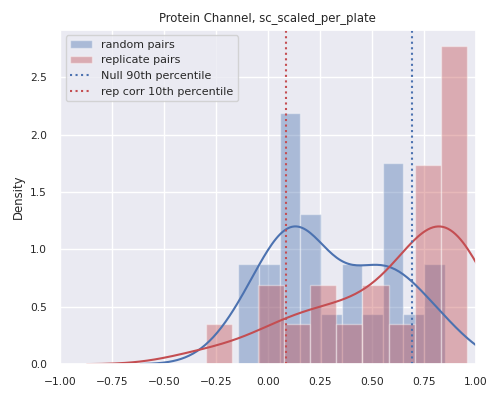

/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


np NonProtein Channels


<IPython.core.display.Javascript object>


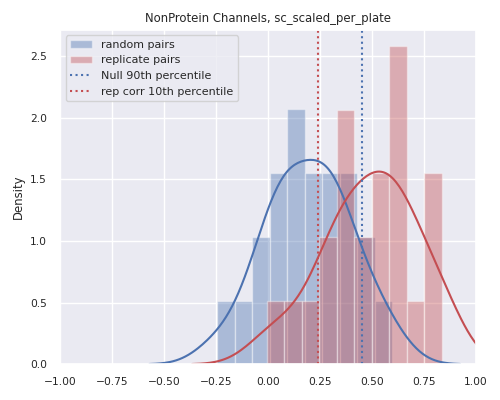

/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [107]:
from singlecell.process.replicate_correlation import replicate_null_corr_coefs
from singlecell.process.normalize_funcs import *

df_rep_level=df_scaled_annot[df_scaled_annot['n_transf']>0].reset_index(drop=True)
df_rep_level=df_rep_level[df_rep_level['tranfection_status']==1].reset_index(drop=True)

df_rep_level_scaled=standardize_per_catX(df_rep_level,'Metadata_Plate',cpFeats_P+cpFeats_NP).copy();

# df_rep_level_scaled = standardize_df_columns(df_rep_level_scaled,cpFeats_P+cpFeats_NP,'Standard')

nOfReps=df_rep_level_scaled.groupby(['Metadata_Sample_Unique']).size().reset_index()
pairWithReplicates=nOfReps.loc[nOfReps[0]!=1,:].reset_index()['Metadata_Sample_Unique']#.groupby([0]).size()

scal_status=df_rep_level_scaled['normalization'].unique()[0]

pertColName='Metadata_Sample_Unique'
repCor4impactList=[]
for f,ch,t in zip([cpFeats_P,cpFeats_NP],['p','np'],['Protein Channel','NonProtein Channels']):
    print(ch,t)
    t2=t+', '+scal_status
    null_corr_ls,rep_corr_ls,repCorrDf=replicate_null_corr_coefs(df_rep_level_scaled,pertColName,f,1,title=t2,hist_bins=10)
    repCorrDf=repCorrDf.add_suffix('_'+ch)
    repCor4impactList.append(repCorrDf);
    
repCorr_df_avg=pd.concat(repCor4impactList,axis=1).reset_index().rename(columns={'index':pertColName})
df_rep_level_scaled=pd.merge(df_rep_level_scaled,repCorr_df_avg,how='left',on=pertColName)

In [109]:

df_rep_level_scaledpairWithReplicates

In [ ]:
df_trt_level=df_rep_level_scaled.groupby(['Metadata_Sample_Unique'])\
.mean().reset_index();

In [114]:
df_rep_level_scaled.groupby(['Metadata_Sample_Unique']).size()

Metadata_Sample_Unique
516 - TC-3                                1
ACSF3 ALA197THR-12                        1
ACSF3 ALA197THR-18                        1
ACSF3 ALA197THR-3                         1
ACSF3 ALA197THR-6                         1
                                         ..
TPM1 (ENDO-FREE, HAND PREP) ASP175AS-6    1
ZBTB24-12                                 1
ZBTB24-18                                 1
ZBTB24-3                                  1
ZBTB24-6                                  1
Length: 251, dtype: int64

In [116]:
# pairWithReplicates

In [111]:
# len(cpFeats_P+cpFeats_NP),df_rep_level_scaled.shape
# df_rep_level_scaled

In [8]:
save_batch_fname='2022_08_22_Batch_1'
scal_status='sc_scaled_per_plate'
# scal_status='raw'
df_selected_pop_profiles0=df_scaled_annot[(df_scaled_annot['zscored'].isnull()) & (df_scaled_annot['normalization']==scal_status)].reset_index(drop=True)
df_selected_pop_profiles0=standardize_per_catX(df_selected_pop_profiles0,'Metadata_Plate',cpFeats_P+cpFeats_NP);

df_batch_up, cp_features_analysis_null_removed = handle_nans.handle_nans(df_selected_pop_profiles0,cpFeats_NP+cpFeats_P,\
                                                                      thrsh_null_ratio=0)

if len(cpFeats_NP+cpFeats_P) > len(cp_features_analysis_null_removed):
    print(len(cpFeats_NP),len(cpFeats_P))
    cpFeats_NP=list(set(cp_features_analysis_null_removed) & set(cpFeats_NP))
    cpFeats_P=list(set(cp_features_analysis_null_removed) & set(cpFeats_P))        
    print(len(cpFeats_NP),len(cpFeats_P))
    df_selected_pop_profiles0=df_batch_up.copy()

df_selected_pop_profiles = standardize_df_columns(df_selected_pop_profiles0,cpFeats_P+cpFeats_NP,'Standard')
repCorr_df_avg=pd.concat(repCor4impactList,axis=1).reset_index().rename(columns={'index':'Metadata_variant_dose'})
df_scaled_annot_rc=pd.merge(df_selected_pop_profiles,repCorr_df_avg,how='left',on='Metadata_variant_dose')

cp_features: 2817
cols2remove_manyNulls []
cols2remove_lowVars []
len cp_features_analysis/nan cols/low vars: 2817 0 0


In [11]:
# pd.concat(repCor4impactList,axis=1).reset_index()

In [112]:
# df_scaled_annot_rc
# print(repCorr_df_avg.to_markdown())

In [113]:
# print(repCorr_df_avg.to_markdown())

### UMAPS

<IPython.core.display.Javascript object>


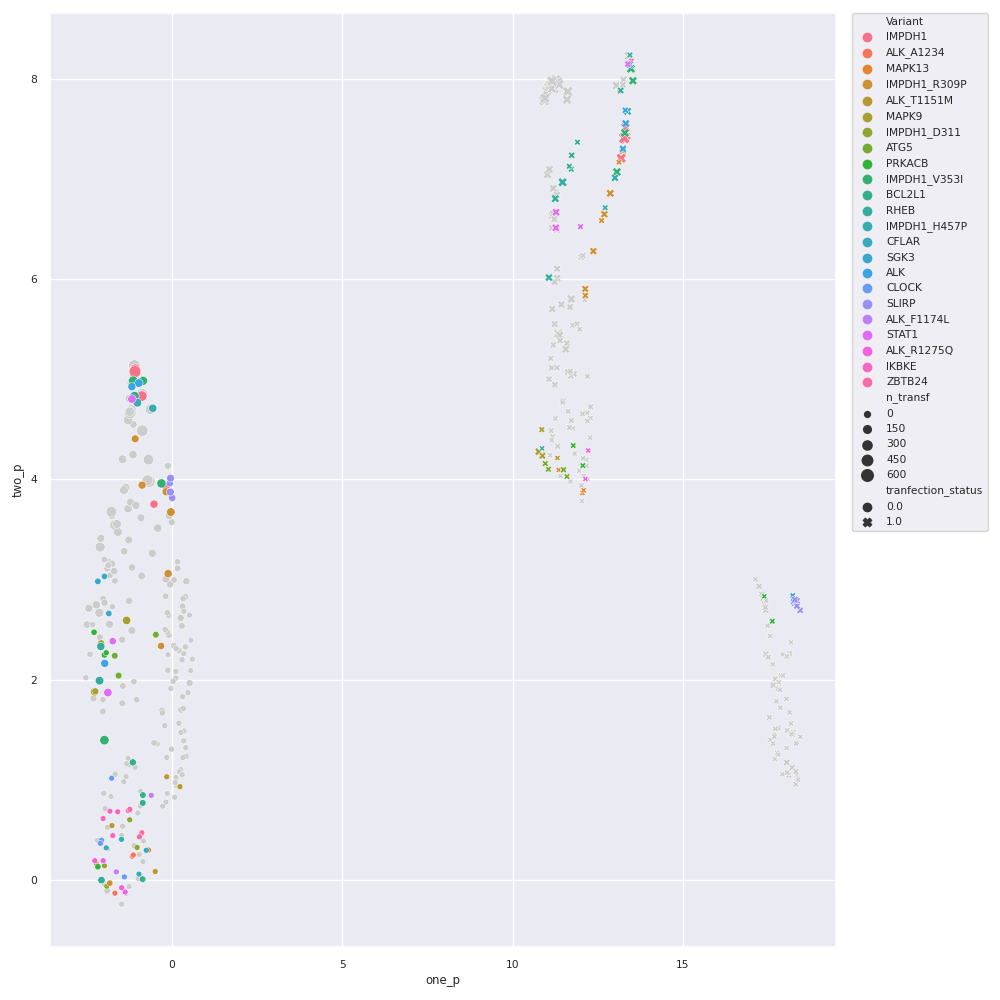

<IPython.core.display.Javascript object>


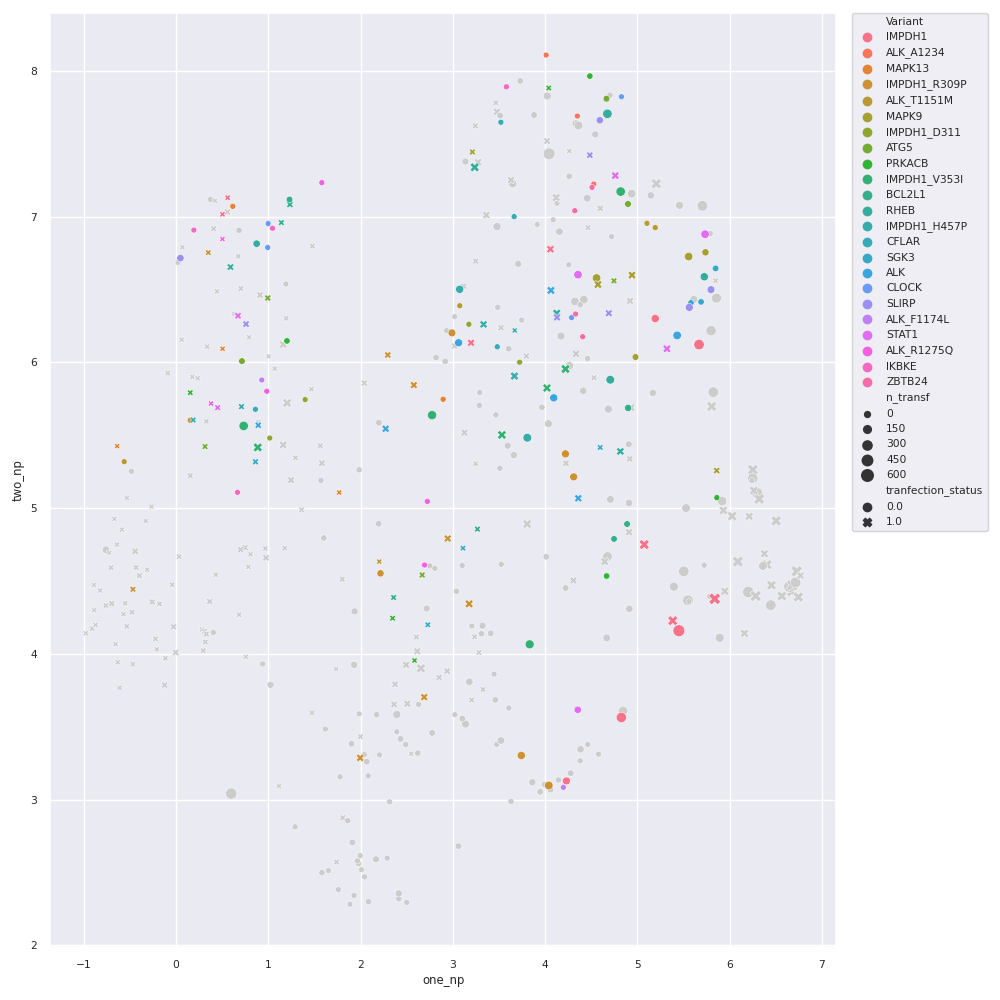

In [12]:
import umap


for f,ch,t in zip([cpFeats_P,cpFeats_NP],['p','np'],['Protein Channel','NonPretein Channels']):

    umapT=umap.UMAP(transform_seed=100)
    Y = umapT.fit_transform(df_selected_pop_profiles[f])
    df_selected_pop_profiles['one_'+ch]=Y[:,0]
    df_selected_pop_profiles['two_'+ch]=Y[:,1]

    plt.figure(figsize=(10,10))
    # sns.scatterplot(x=one_dim, y=two_dim, hue="Metadata_Plate",style="Controls", data=df_scaled_annot_filt,legend=True);
    # plt.figure(figsize=(15,15))
    # sns.scatterplot(x=one_dim, y=two_dim, hue="Controls", data=df_scaled_annot_filt,legend=True);
    # # ax=sns.scatterplot(x=one_dim, y=two_dim, size="n_transf", data=df_scaled_annot_filt[df_scaled_annot_filt['Controls']==''],legend=True);
    # plt.figure(figsize=(15,15))
    sns.scatterplot(x='one_'+ch, y='two_'+ch,size="n_transf",style="tranfection_status", data=df_selected_pop_profiles,color=".8",legend=False);
    sns.scatterplot(x='one_'+ch, y='two_'+ch, hue="Variant",size="n_transf",style="tranfection_status",\
                    data=df_selected_pop_profiles[df_selected_pop_profiles['control_type'].isin(['poscon','negcon'])],legend=True);
    # sns.scatterplot(x=one_dim, y="two_dim, hue="Gene",style="Controls", data=df_scaled_annot_filt,legend=True);

    # sns.scatterplot(x=one_dim, y=two_dim, hue="Metadata_Plate",style="modality", data=merged_shared,legend=False);
    # sns.scatterplot(x=one_dim, y=two_dim, data=merged_shared[merged_shared['PERT']=='DMSO'],color='r',s=200, marker="o");
    # sns.scatterplot(x=one_dim, y=two_dim, hue="split", data=merged_shared[merged_shared['split']!=''],s=100, marker="+");

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    
df_selected_pop_profiles[df_selected_pop_profiles['tranfection_status']==1] = standardize_df_columns(df_selected_pop_profiles[df_selected_pop_profiles[\
                                                    'tranfection_status']==1],cpFeats_P,'Standard')

Nuclei_Correlation_K_Mito_GFP                         -0.254740
Cytoplasm_Texture_Variance_GFP_10_03_256              -0.144944
Nuclei_Texture_SumVariance_GFP_10_01_256              -0.166298
Cytoplasm_Texture_Correlation_GFP_5_00_256             0.314807
Cytoplasm_Correlation_Manders_AGP_GFP                  0.250834
                                                         ...   
Cells_Texture_InverseDifferenceMoment_GFP_10_03_256    0.447104
Cytoplasm_Texture_SumEntropy_GFP_20_00_256            -0.450638
Cells_Texture_Variance_GFP_10_00_256                  -0.154994
Cytoplasm_RadialDistribution_FracAtD_GFP_4of10        -0.238503
Nuclei_Texture_SumEntropy_GFP_10_02_256               -0.451217
Length: 715, dtype: float64

In [16]:
# df_selected_pop_profiles[df_selected_pop_profiles['tranfection_status']==1]

In [249]:
# df_selected_pop_profiles[df_selected_pop_profiles['tranfection_status']==1] = standardize_df_columns(df_selected_pop_profiles[df_selected_pop_profiles[\
#                                                     'tranfection_status']==1],cpFeats_P,'Standard')

<IPython.core.display.Javascript object>


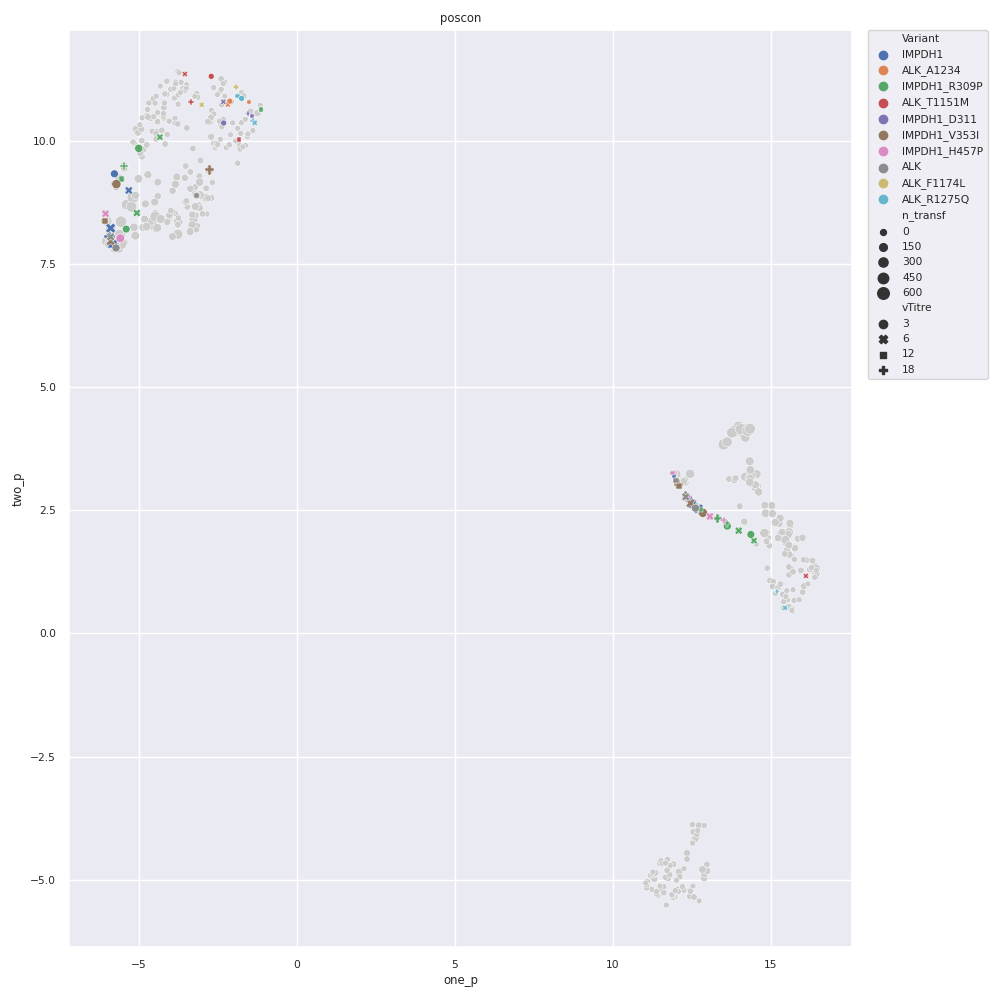

<IPython.core.display.Javascript object>


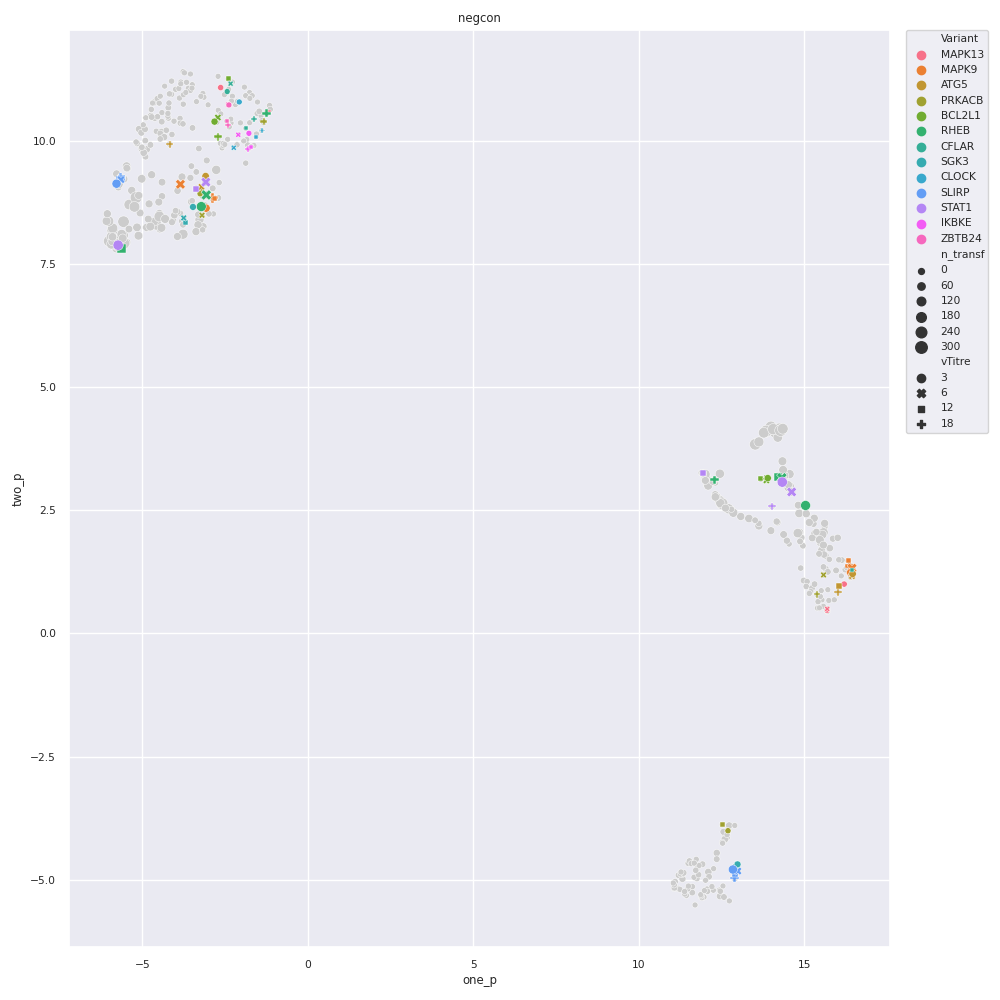

<IPython.core.display.Javascript object>


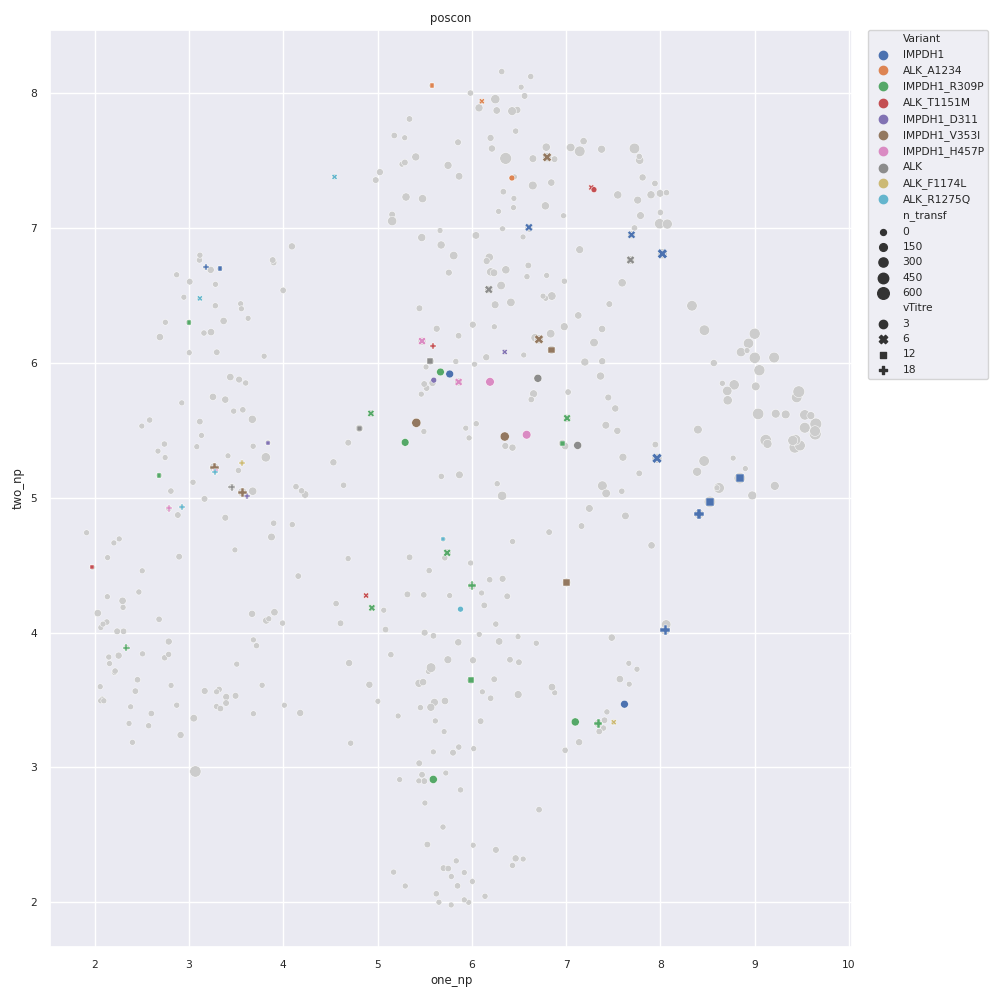

<IPython.core.display.Javascript object>


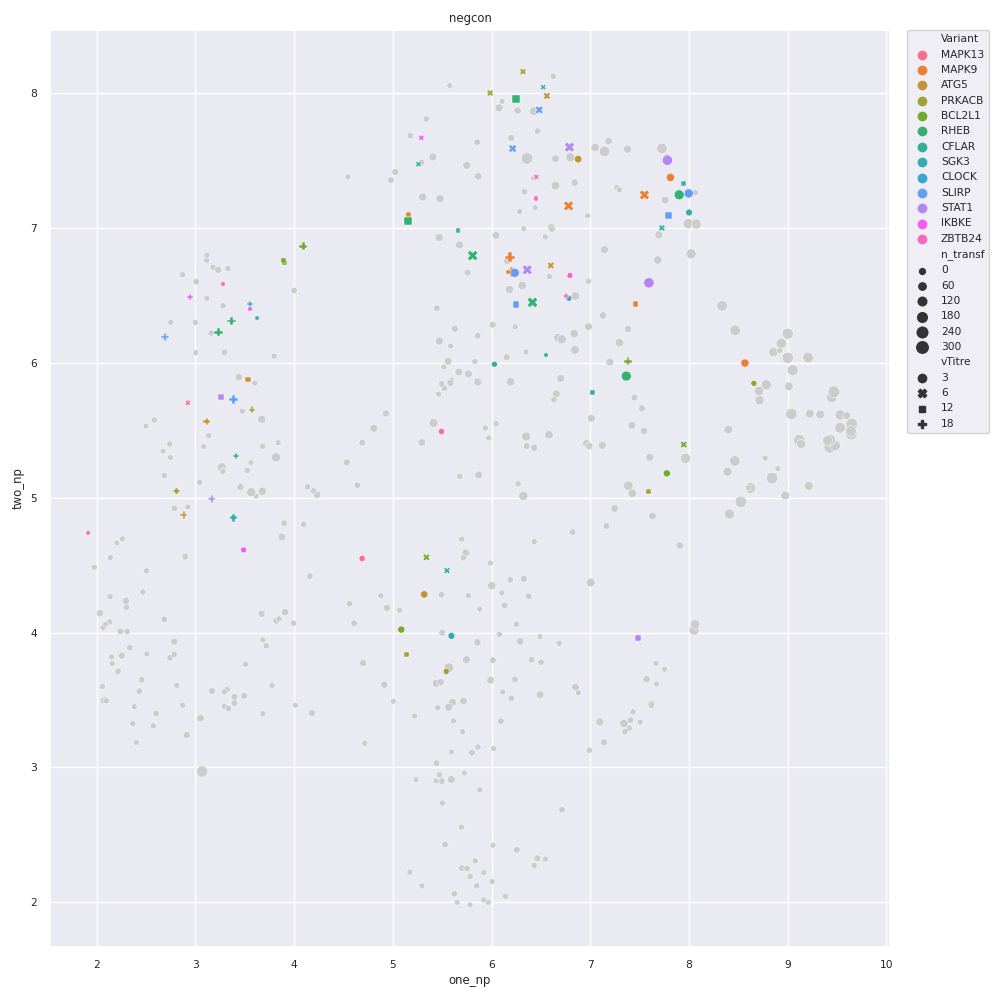

In [251]:
import umap


for f,ch,t in zip([cpFeats_P,cpFeats_NP],['p','np'],['Protein Channel','NonPretein Channels']):
    for control_type in ['poscon','negcon']:
#         umapT=umap.UMAP(transform_seed=40)
#         Y = umapT.fit_transform(df_selected_pop_profiles[f])
#         df_selected_pop_profiles['one_'+ch]=Y[:,0]
#         df_selected_pop_profiles['two_'+ch]=Y[:,1]

        plt.figure(figsize=(10,10))
        # sns.scatterplot(x=one_dim, y=two_dim, hue="Metadata_Plate",style="Controls", data=df_scaled_annot_filt,legend=True);
        # plt.figure(figsize=(15,15))
        # sns.scatterplot(x=one_dim, y=two_dim, hue="Controls", data=df_scaled_annot_filt,legend=True);
        # # ax=sns.scatterplot(x=one_dim, y=two_dim, size="n_transf", data=df_scaled_annot_filt[df_scaled_annot_filt['Controls']==''],legend=True);
        # plt.figure(figsize=(15,15))
        sns.scatterplot(x='one_'+ch, y='two_'+ch,size="n_transf", data=df_selected_pop_profiles,color=".8",legend=False);
        sns.scatterplot(x='one_'+ch, y='two_'+ch, hue="Variant",size="n_transf",style="vTitre",\
                        data=df_selected_pop_profiles[df_selected_pop_profiles['control_type'].isin([control_type])],legend=True);
        # sns.scatterplot(x=one_dim, y="two_dim, hue="Gene",style="Controls", data=df_scaled_annot_filt,legend=True);

        # sns.scatterplot(x=one_dim, y=two_dim, hue="Metadata_Plate",style="modality", data=merged_shared,legend=False);
        # sns.scatterplot(x=one_dim, y=two_dim, data=merged_shared[merged_shared['PERT']=='DMSO'],color='r',s=200, marker="o");
        # sns.scatterplot(x=one_dim, y=two_dim, hue="split", data=merged_shared[merged_shared['split']!=''],s=100, marker="+");

#         pX_wt,pY_wt=WT_dmso[['one_'+ch,'two_'+ch]].mean().values
#         pX_mt,pY_mt=MT_dmso[['one_'+ch,'two_'+ch]].mean().values
#         ax.annotate("", xy=(pX_mt,pY_mt), xytext=(pX_wt, pY_wt),arrowprops=dict(arrowstyle="->",color='b'))

                    
        
        plt.title(control_type)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.tight_layout()

In [272]:
df_selected_pop_profiles['vTitre'].unique()

array([18, 12,  6,  3])

<IPython.core.display.Javascript object>


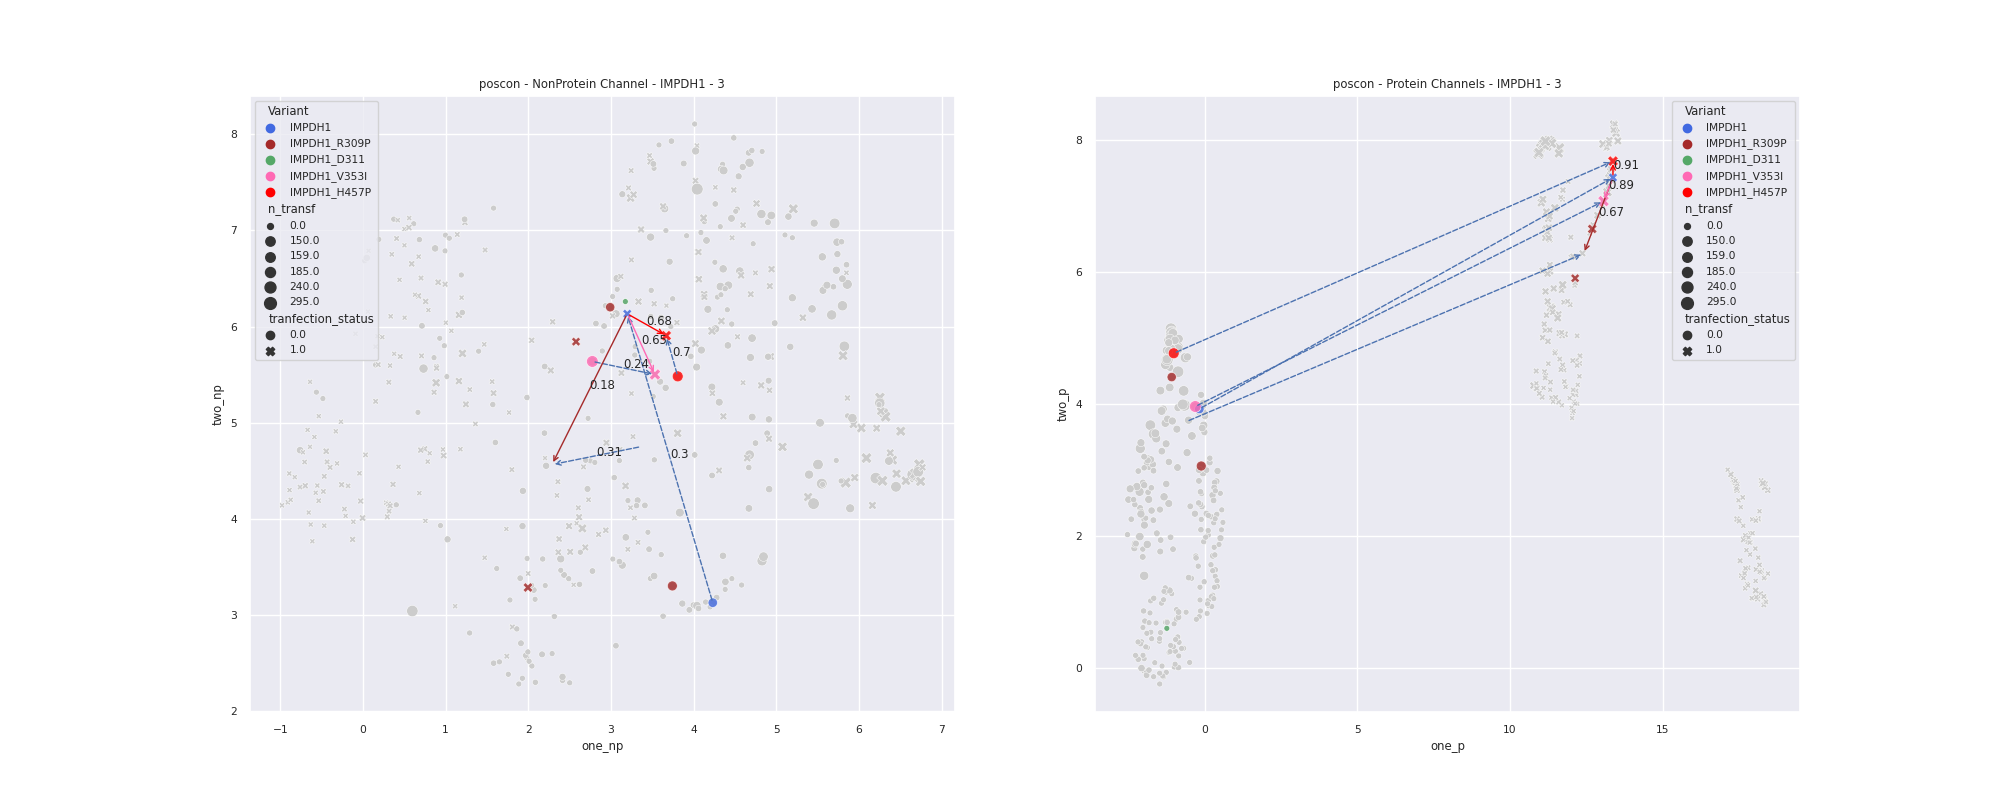

<IPython.core.display.Javascript object>


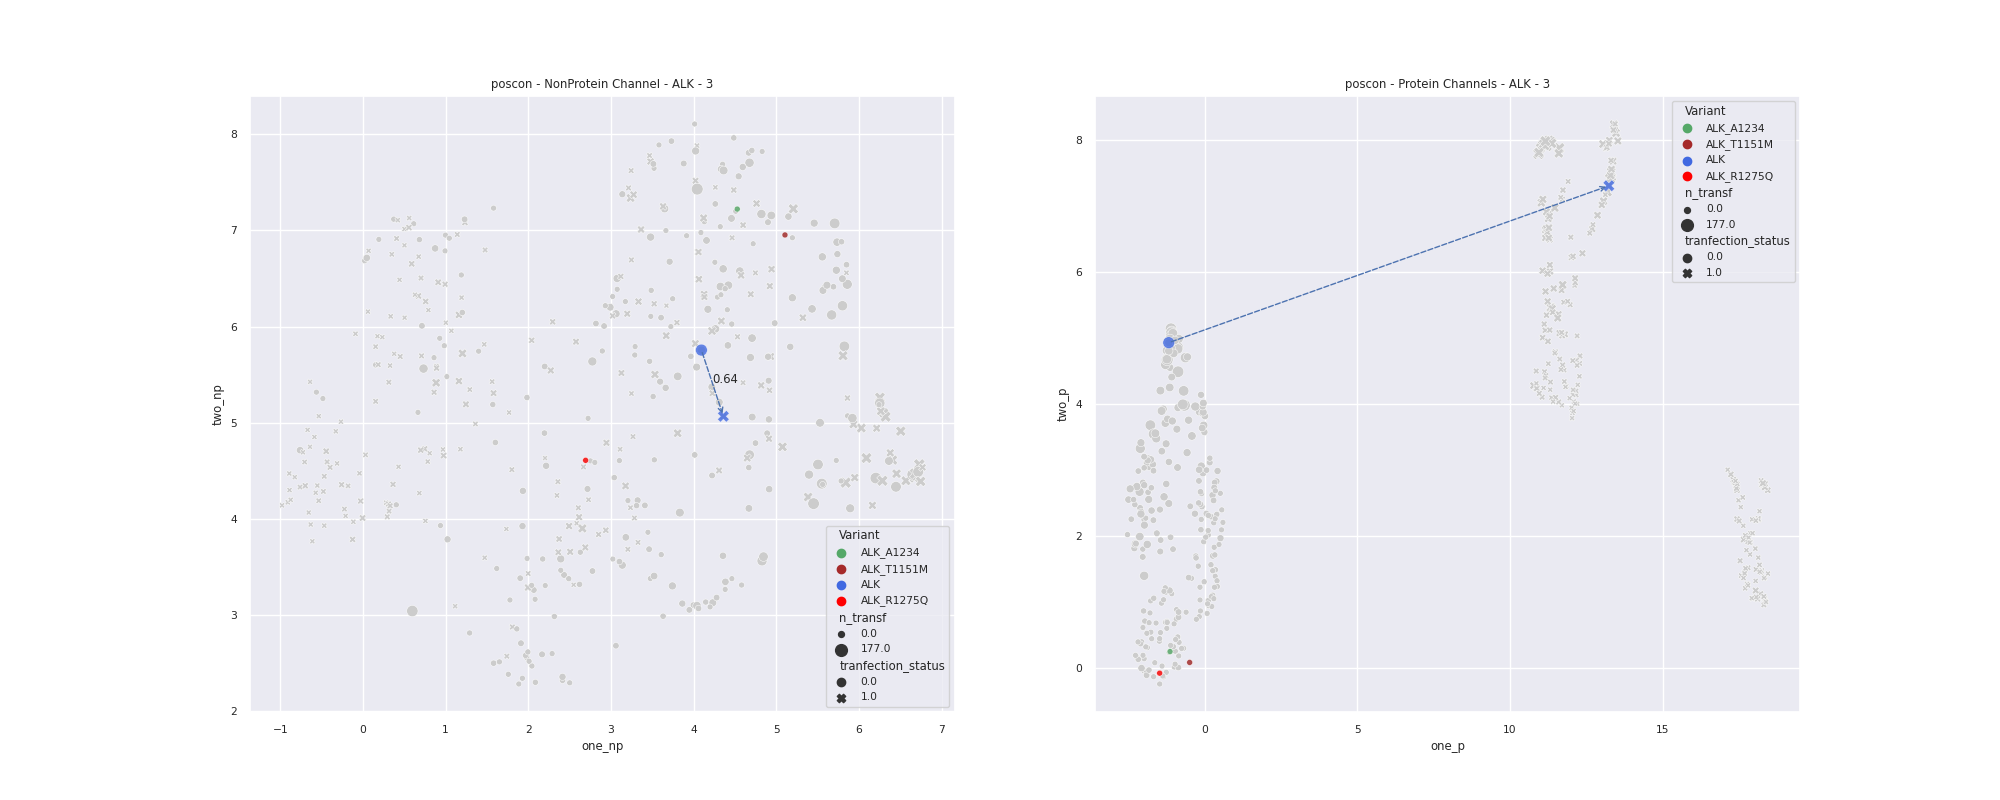

<IPython.core.display.Javascript object>


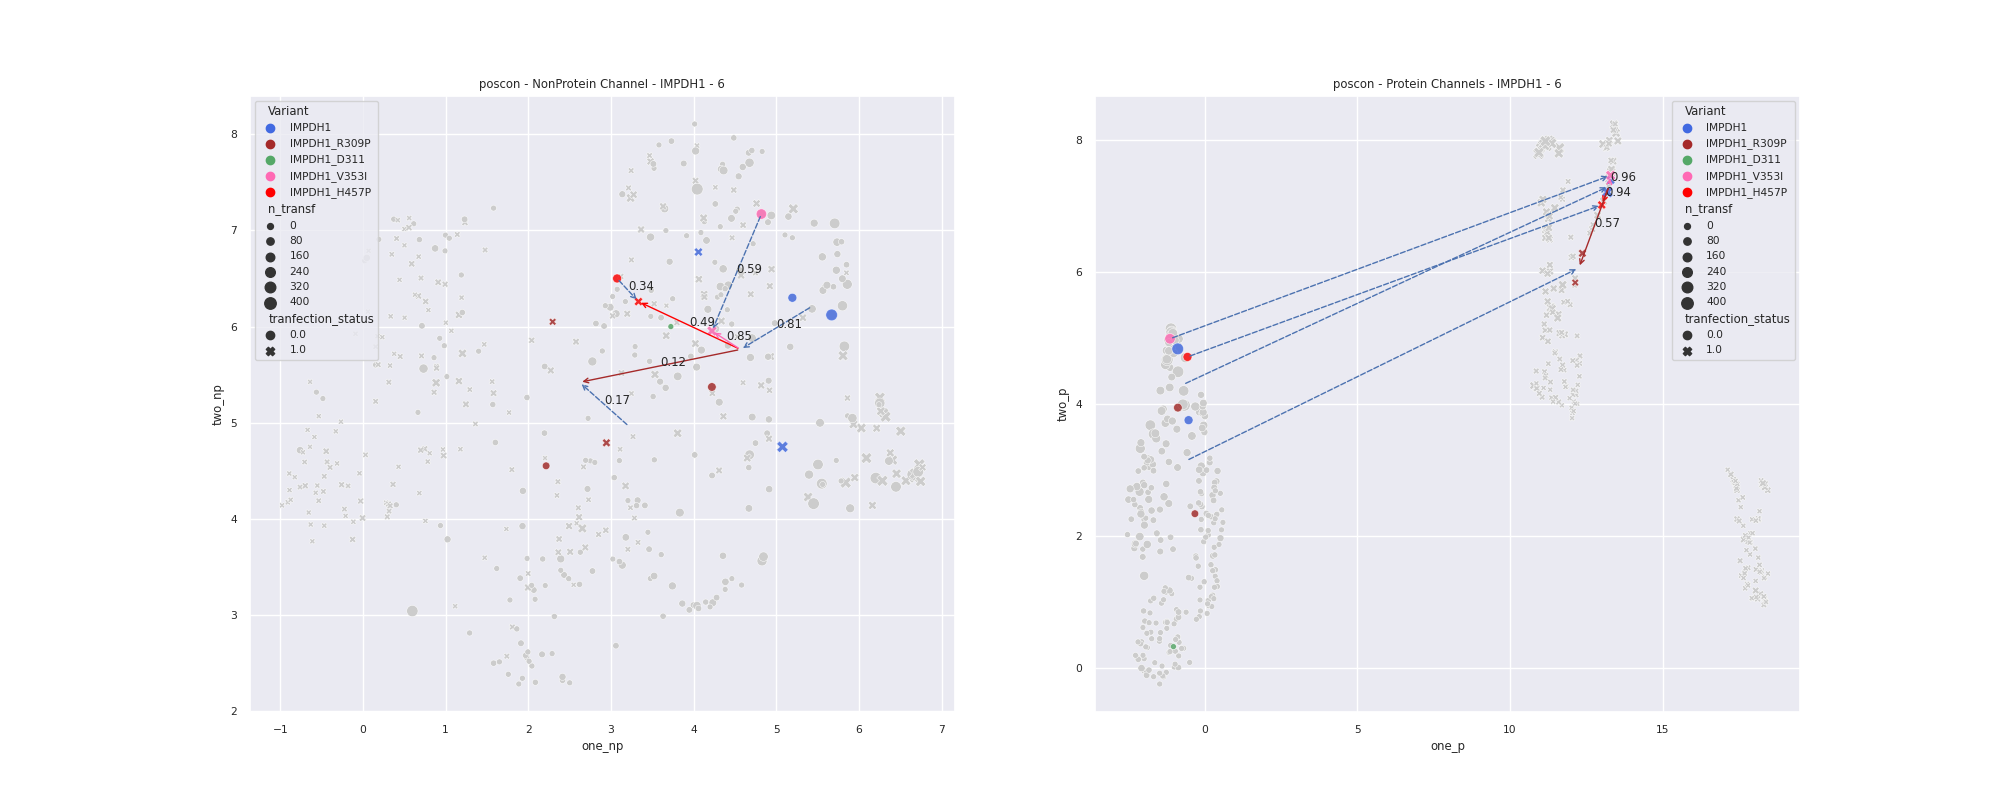

<IPython.core.display.Javascript object>


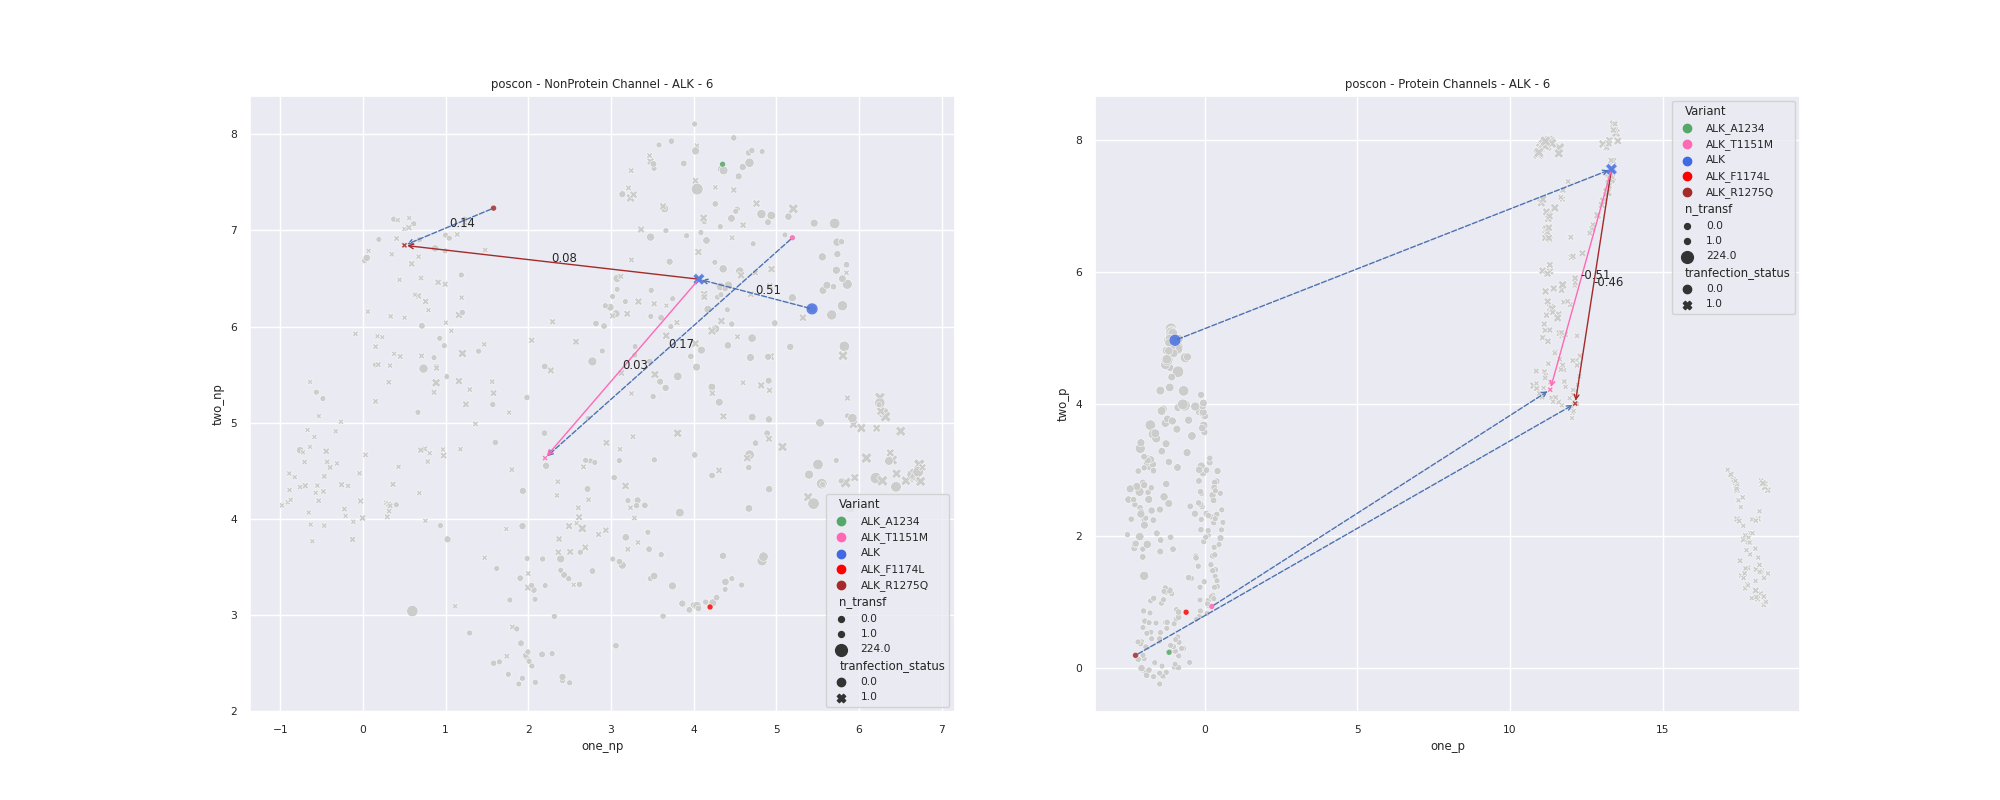

<IPython.core.display.Javascript object>


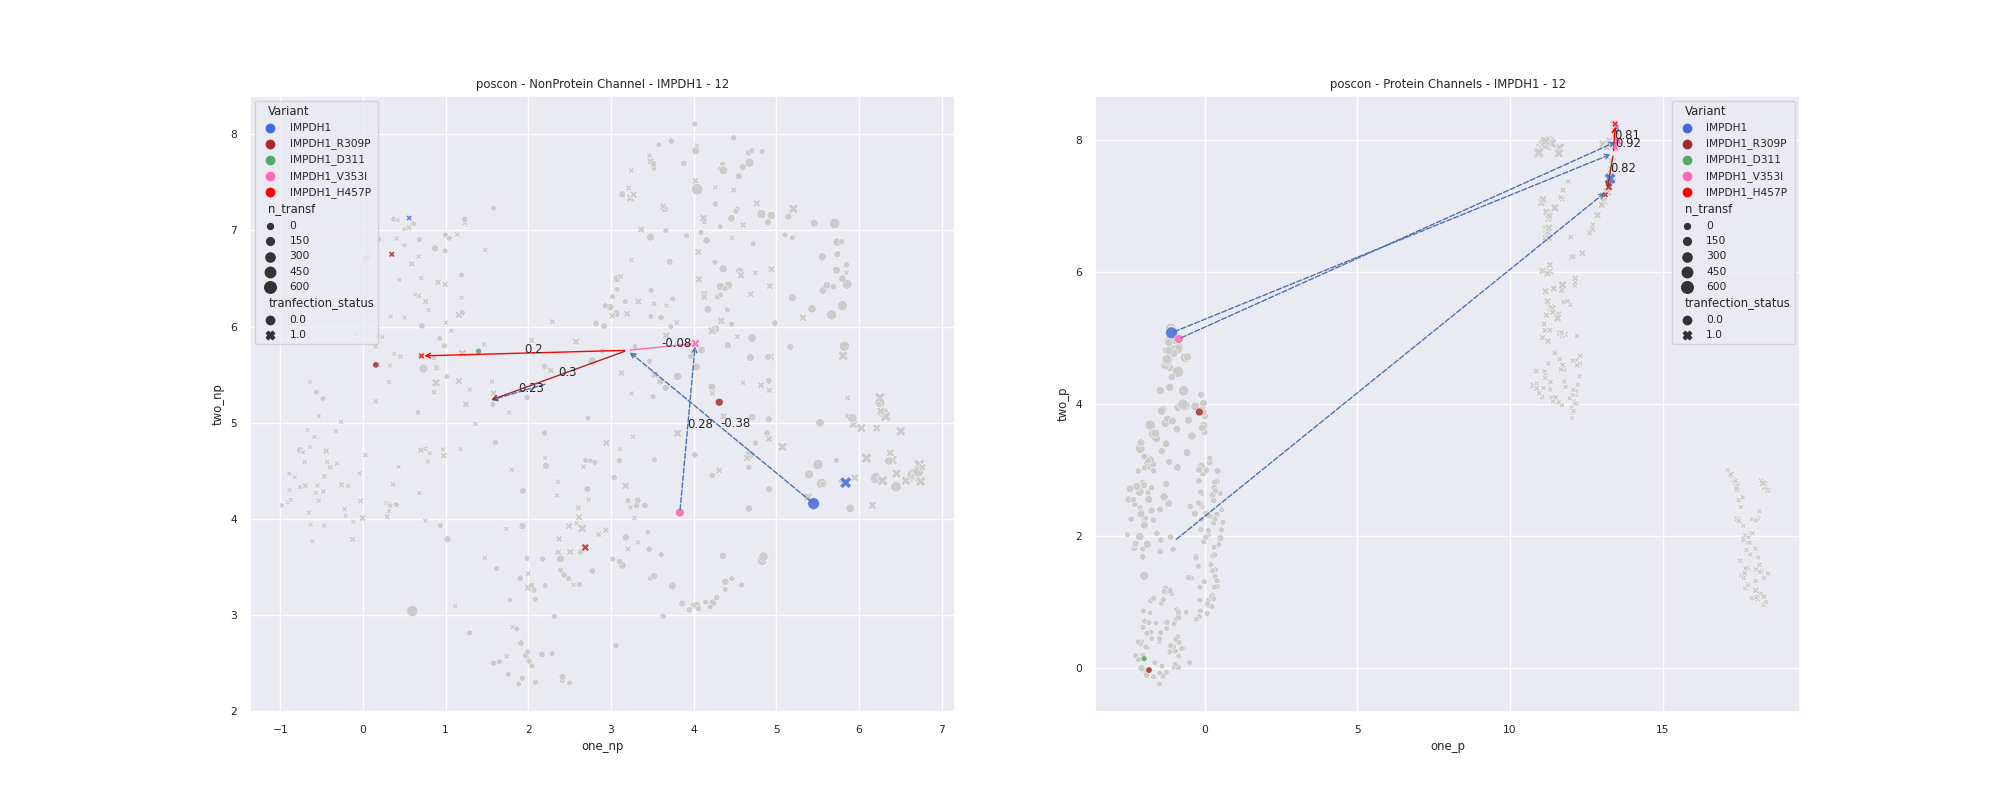

<IPython.core.display.Javascript object>


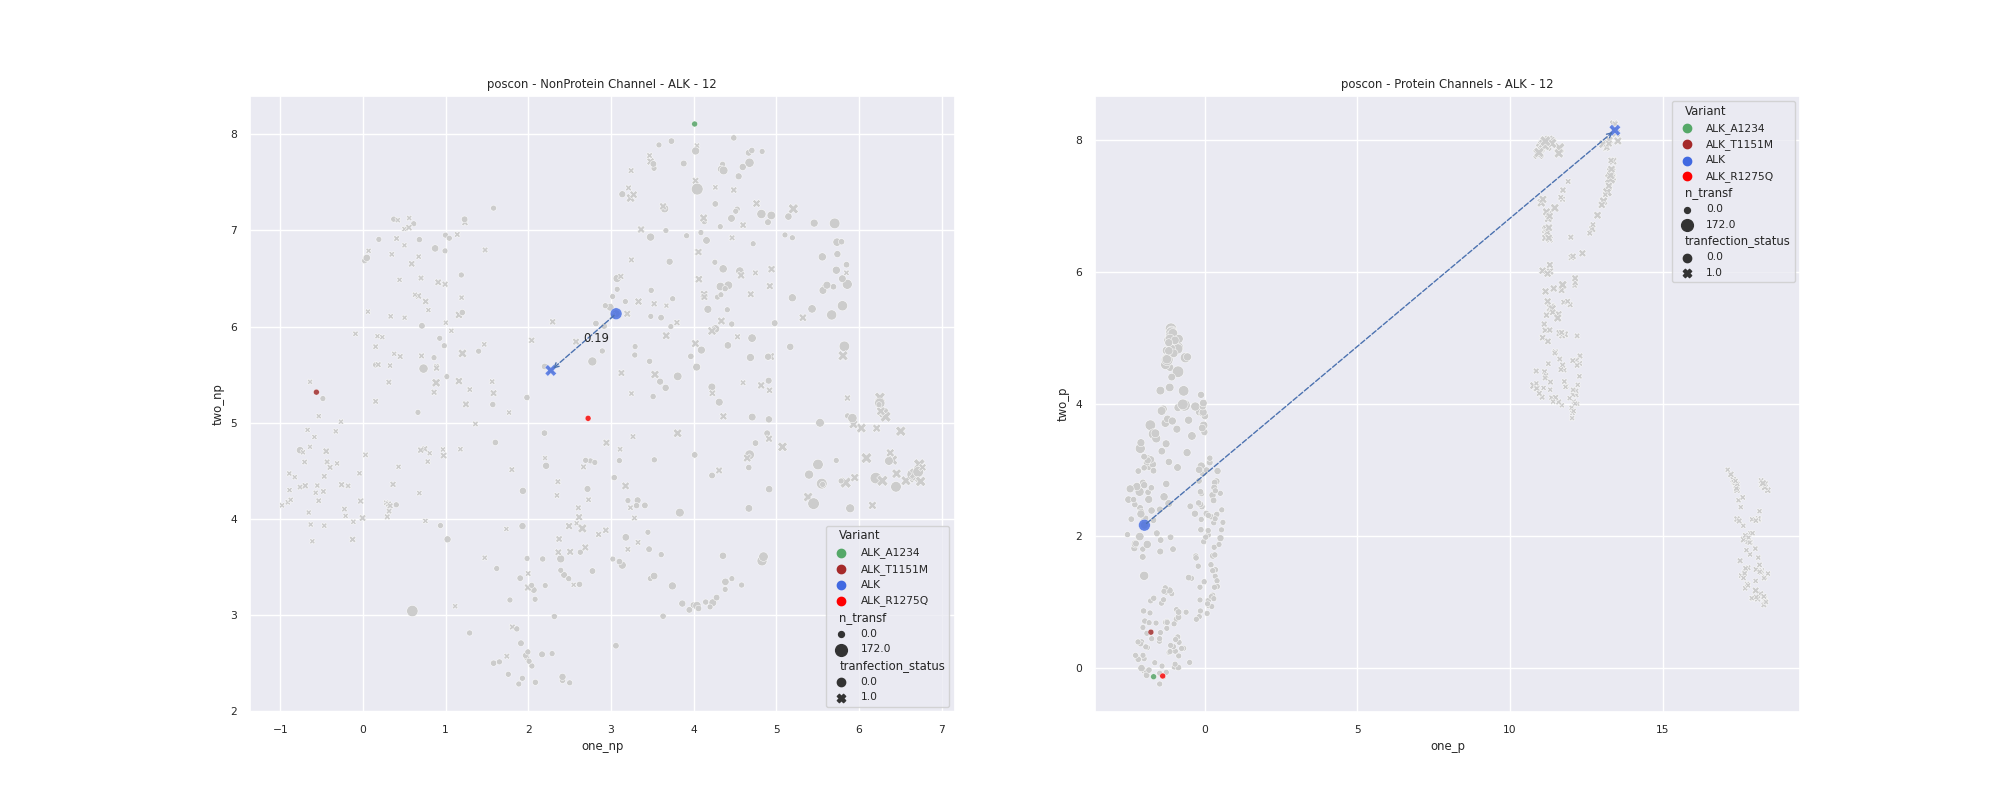

<IPython.core.display.Javascript object>


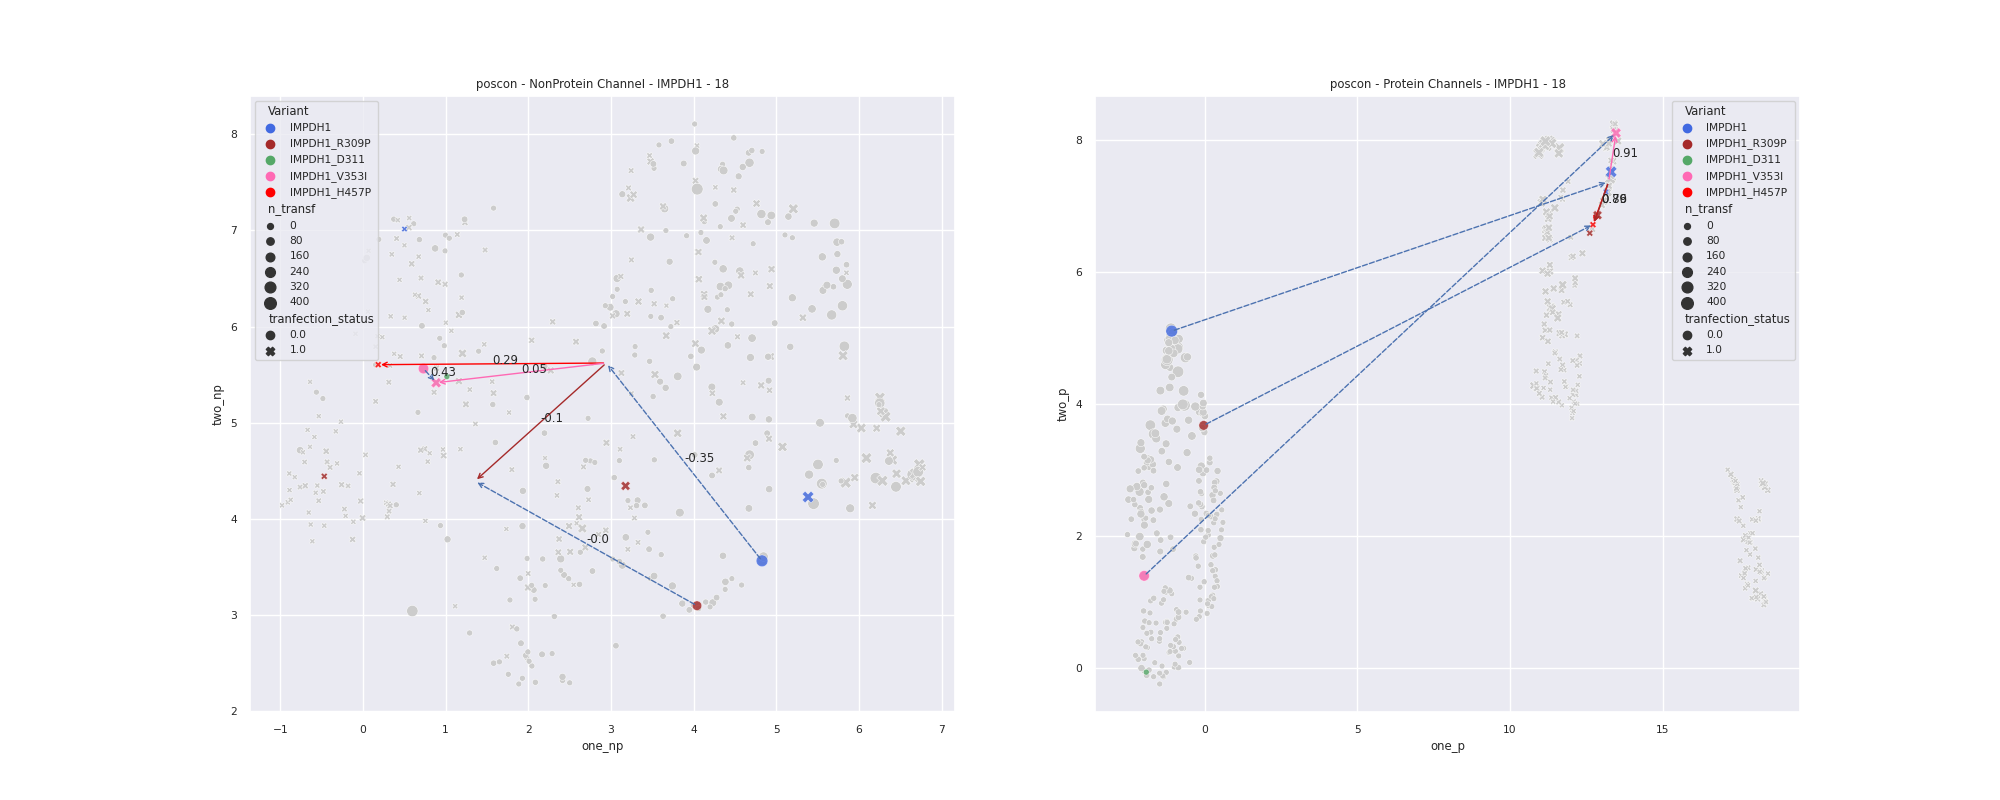

<IPython.core.display.Javascript object>


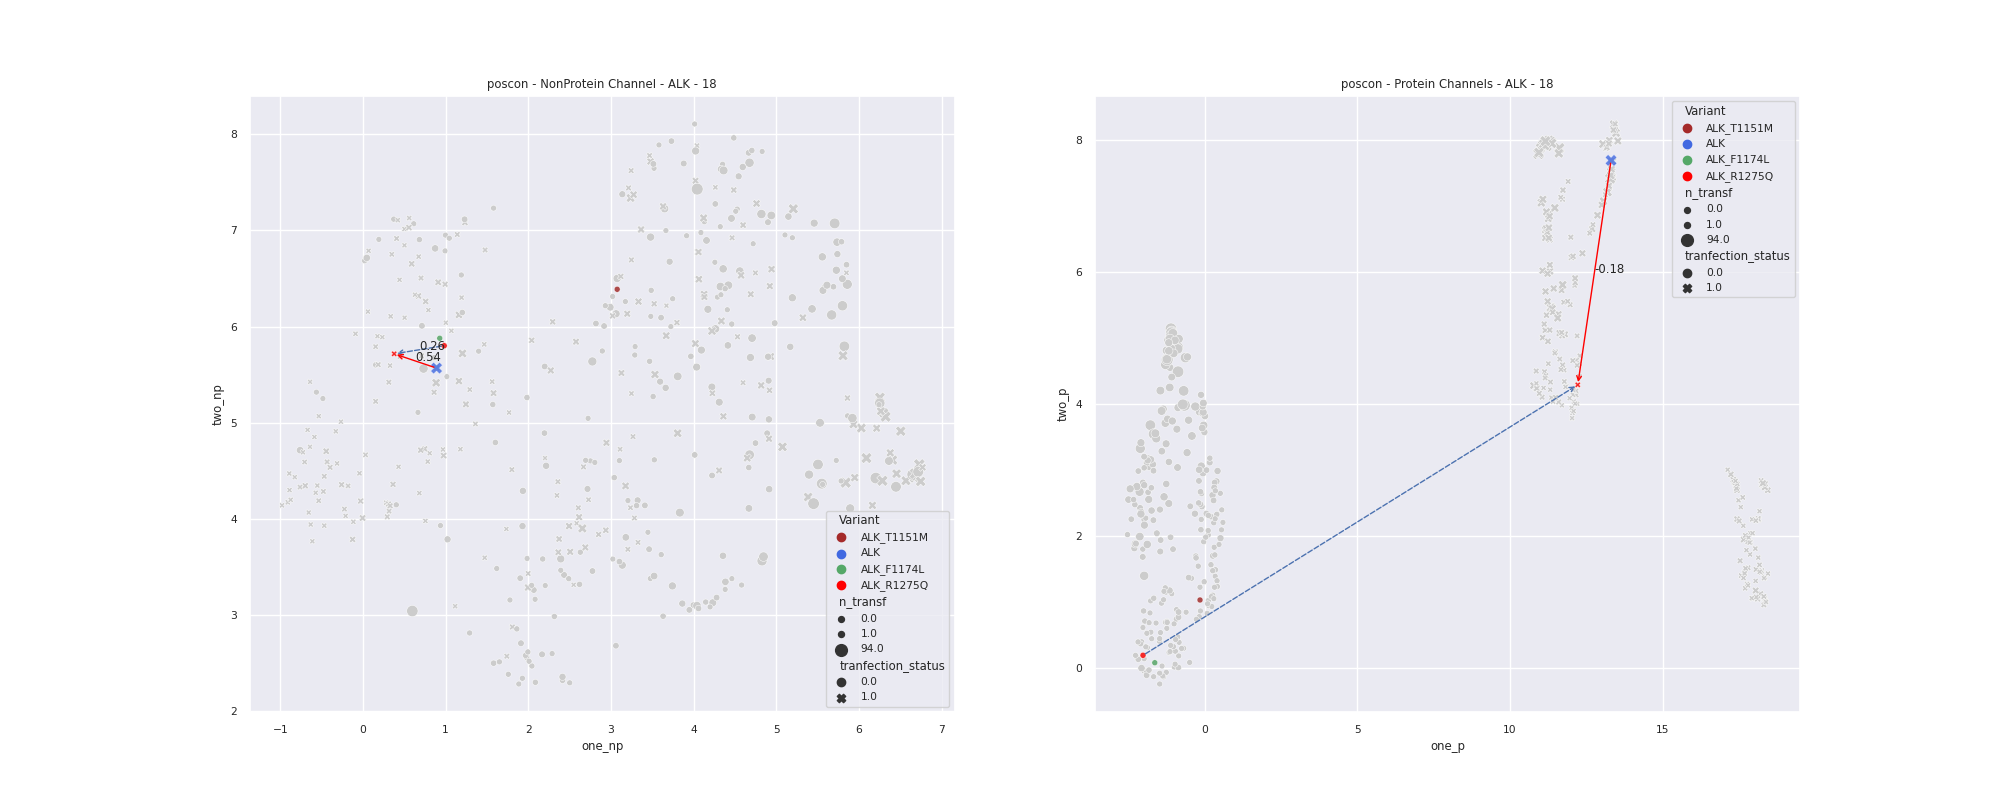

In [18]:

vcolors=['royalblue','g','red','brown','hotpink','lightgreen','slateblue']

# results_df=df_selected_pop_profiles.loc[df_selected_pop_profiles['control_type'].isin([control_type]),\
#                                        ['Variant','control_type', 'vTitre']]
results_df= pd.DataFrame(columns = ['Variant','control_type', 'vTitre', 'channel','impact_versus_untransfected','impact_vs_wt'])


for control_type in ['poscon']:
    
    for vt in [3,6,12,18]:
        xcon=df_selected_pop_profiles[(df_selected_pop_profiles['control_type']==control_type) &\
                                     (df_selected_pop_profiles['vTitre']==vt)].reset_index(drop=True)
    #         sfsfs

        genes=xcon['Gene'].unique()

        for g in genes:
            xcon_g=xcon[xcon['Gene']==g]
            ls_of_vars=np.sort(xcon_g['Variant'].unique())

    #             plt.figure(figsize=(8,8))
            palette = {}
            for i1 in range(len(ls_of_vars)):
                palette[ls_of_vars[i1]]=vcolors[i1]            


            fig, ax = plt.subplots(1,2,figsize=(20,8))
            for fi,f,ch,t in zip([0,1],[cpFeats_NP,cpFeats_P],['np','p'],['NonProtein Channel','Protein Channels']):   

                ax[fi].set_title(control_type+' - '+ t+' - '+g +' - '+str(vt))
                sns.scatterplot(x='one_'+ch, y='two_'+ch,size="n_transf", data=df_selected_pop_profiles,color=".8",\
                                style="tranfection_status",ax=ax[fi],legend=False);
                sns.scatterplot(x='one_'+ch, y='two_'+ch, hue="Variant",size="n_transf",style="tranfection_status",\
                                data=xcon_g,palette=palette,alpha=0.8,legend=True,ax=ax[fi]);


                for v in ls_of_vars:

                    xcon_gv=xcon[xcon['Variant']==v].reset_index(drop=True)

                    res_ls=[v,control_type,vt,ch]
                    if xcon_gv['tranfection_status'].unique().shape[0]==2:

                        if ch=='np':
                            cc_to_untrans=np.round(scipy.stats.pearsonr(xcon_gv.loc[xcon_gv['tranfection_status']==0,f].mean().values,\
                                                            xcon_gv.loc[xcon_gv['tranfection_status']==1,f].mean().values)[0],2)
                            cc_to_untrans_str=str(cc_to_untrans)
                            res_ls+=[cc_to_untrans,np.nan]
                        else:
                            cc_to_untrans_str=''
                            res_ls+=[np.nan,np.nan]

                        pX_wt,pY_wt=xcon_gv.loc[(xcon_gv['tranfection_status']==0) , ['one_'+ch,'two_'+ch]].mean()
                        pX_mt,pY_mt=xcon_gv.loc[(xcon_gv['tranfection_status']==1) , ['one_'+ch,'two_'+ch]].mean()
        #                 pX_wt,pY_wt=WT_dmso[['one_'+ch,'two_'+ch]].mean().values
        #                 pX_mt,pY_mt=MT_dmso[['one_'+ch,'two_'+ch]].mean().values
                        ax[fi].annotate('', xy=(pX_mt,pY_mt), xytext=(pX_wt, pY_wt),\
                                    arrowprops=dict(arrowstyle="->",color='b',ls='dashed'),va='center')
                        ax[fi].annotate(cc_to_untrans_str,xy=(((pX_mt+pX_wt)/2), (pY_mt+pY_wt)/2))
                    else:
                        res_ls+=[np.nan,np.nan]

                    results_df.loc[len(results_df)] = res_ls


                ls_of_vars2=np.sort(xcon_g[(xcon_g['Variant']!=g) & (xcon_g['tranfection_status']==1)].Variant.unique())
    #             ls_of_vars2.sort();
    #             i=0
                for v in ls_of_vars2:
    #                 i+=1
                    xcon_gg=xcon[xcon['Variant']==g].reset_index(drop=True)
                    xcon_gv=xcon[xcon['Variant']==v].reset_index(drop=True)
                    cc_wt_mt_p=np.round(scipy.stats.pearsonr(xcon_gg.loc[xcon_gg['tranfection_status']==1,f].mean().values,\
                                                    xcon_gv.loc[xcon_gv['tranfection_status']==1,f].mean().values)[0],2)

                    results_df.loc[(results_df['Variant']==v) & (results_df['vTitre']==vt) & (results_df['channel']==ch),\
                                   'impact_vs_wt']=cc_wt_mt_p
                    pX_wt,pY_wt=xcon_gg.loc[(xcon_gg['tranfection_status']==1) , ['one_'+ch,'two_'+ch]].mean()
                    pX_mt,pY_mt=xcon_gv.loc[(xcon_gv['tranfection_status']==1) , ['one_'+ch,'two_'+ch]].mean()
    #                 pX_wt,pY_wt=WT_dmso[['one_'+ch,'two_'+ch]].mean().values
    #                 pX_mt,pY_mt=MT_dmso[['one_'+ch,'two_'+ch]].mean().values
                    ax[fi].annotate('', xy=(pX_mt,pY_mt), xytext=(pX_wt, pY_wt),\
                                arrowprops=dict(arrowstyle="->",color=palette[v]),va='center')
                    ax[fi].annotate(str(cc_wt_mt_p),xy=(((pX_mt+pX_wt)/2), (pY_mt+pY_wt)/2))     
                
                
# sgfgsfgfdsg


In [283]:
print(results_df.to_markdown())

|    | Variant      | control_type   |   vTitre | channel   |   impact_versus_untransfected |   impact_vs_wt |
|---:|:-------------|:---------------|---------:|:----------|------------------------------:|---------------:|
|  0 | IMPDH1       | poscon         |        3 | np        |                          0.3  |         nan    |
|  1 | IMPDH1_D311  | poscon         |        3 | np        |                        nan    |         nan    |
|  2 | IMPDH1_H457P | poscon         |        3 | np        |                          0.7  |           0.68 |
|  3 | IMPDH1_R309P | poscon         |        3 | np        |                          0.31 |           0.18 |
|  4 | IMPDH1_V353I | poscon         |        3 | np        |                          0.24 |           0.65 |
|  5 | IMPDH1       | poscon         |        3 | p         |                        nan    |         nan    |
|  6 | IMPDH1_D311  | poscon         |        3 | p         |                        nan    |         nan    |
|

In [277]:
results_df.loc[len(results_df):len(results_df)+3] = res_ls

In [278]:
results_df

Variant control_type  vTitre  impact_versus_untransfected  \
0         IMPDH1       poscon       3                         0.30   
1    IMPDH1_D311       poscon       3                          NaN   
2   IMPDH1_H457P       poscon       3                         0.70   
3   IMPDH1_R309P       poscon       3                         0.31   
4   IMPDH1_V353I       poscon       3                         0.24   
..           ...          ...     ...                          ...   
69    ALK_T1151M       poscon      18                          NaN   
70           ALK       poscon      18                          NaN   
71    ALK_F1174L       poscon      18                          NaN   
72    ALK_R1275Q       poscon      18                          NaN   
73    ALK_T1151M       poscon      18                          NaN   

    impact_vs_wt  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
69           NaN  
70           NaN  
71           NaN  
72           NaN  
73           NaN  

[74 rows x 5 columns]

In [284]:
# df_selected_pop_profiles.loc[df_selected_pop_profiles['control_type'].isin([control_type])]

<IPython.core.display.Javascript object>


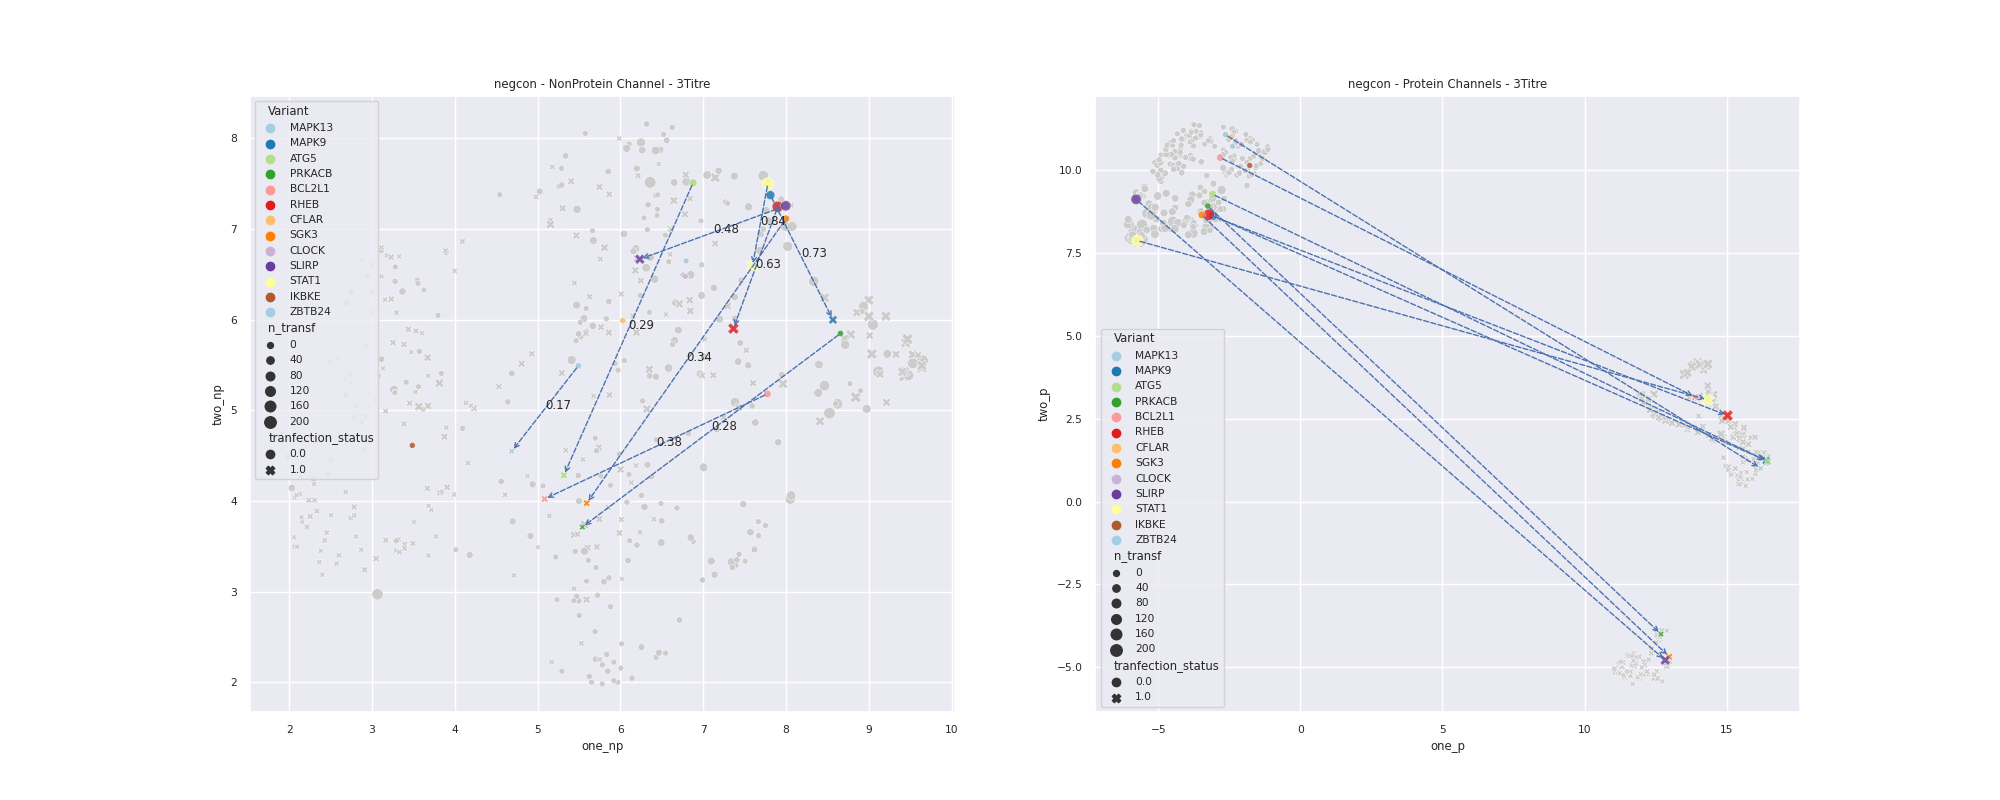

<IPython.core.display.Javascript object>


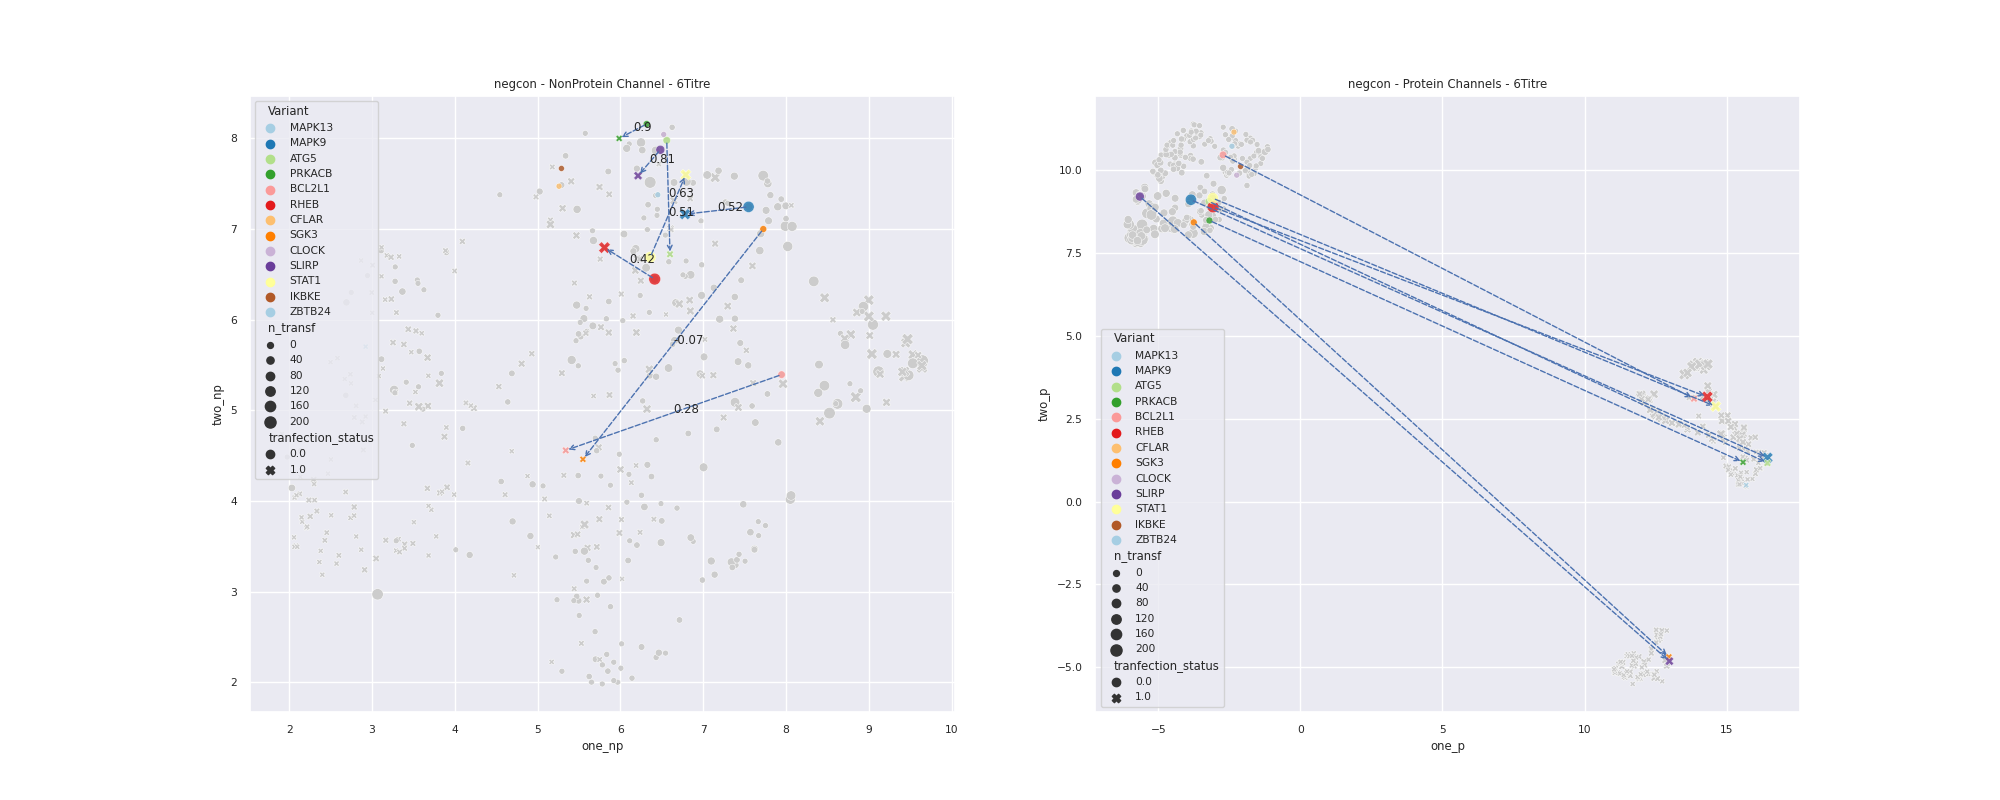

/tmp/ipykernel_76990/3814289277.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,figsize=(20,8))


<IPython.core.display.Javascript object>


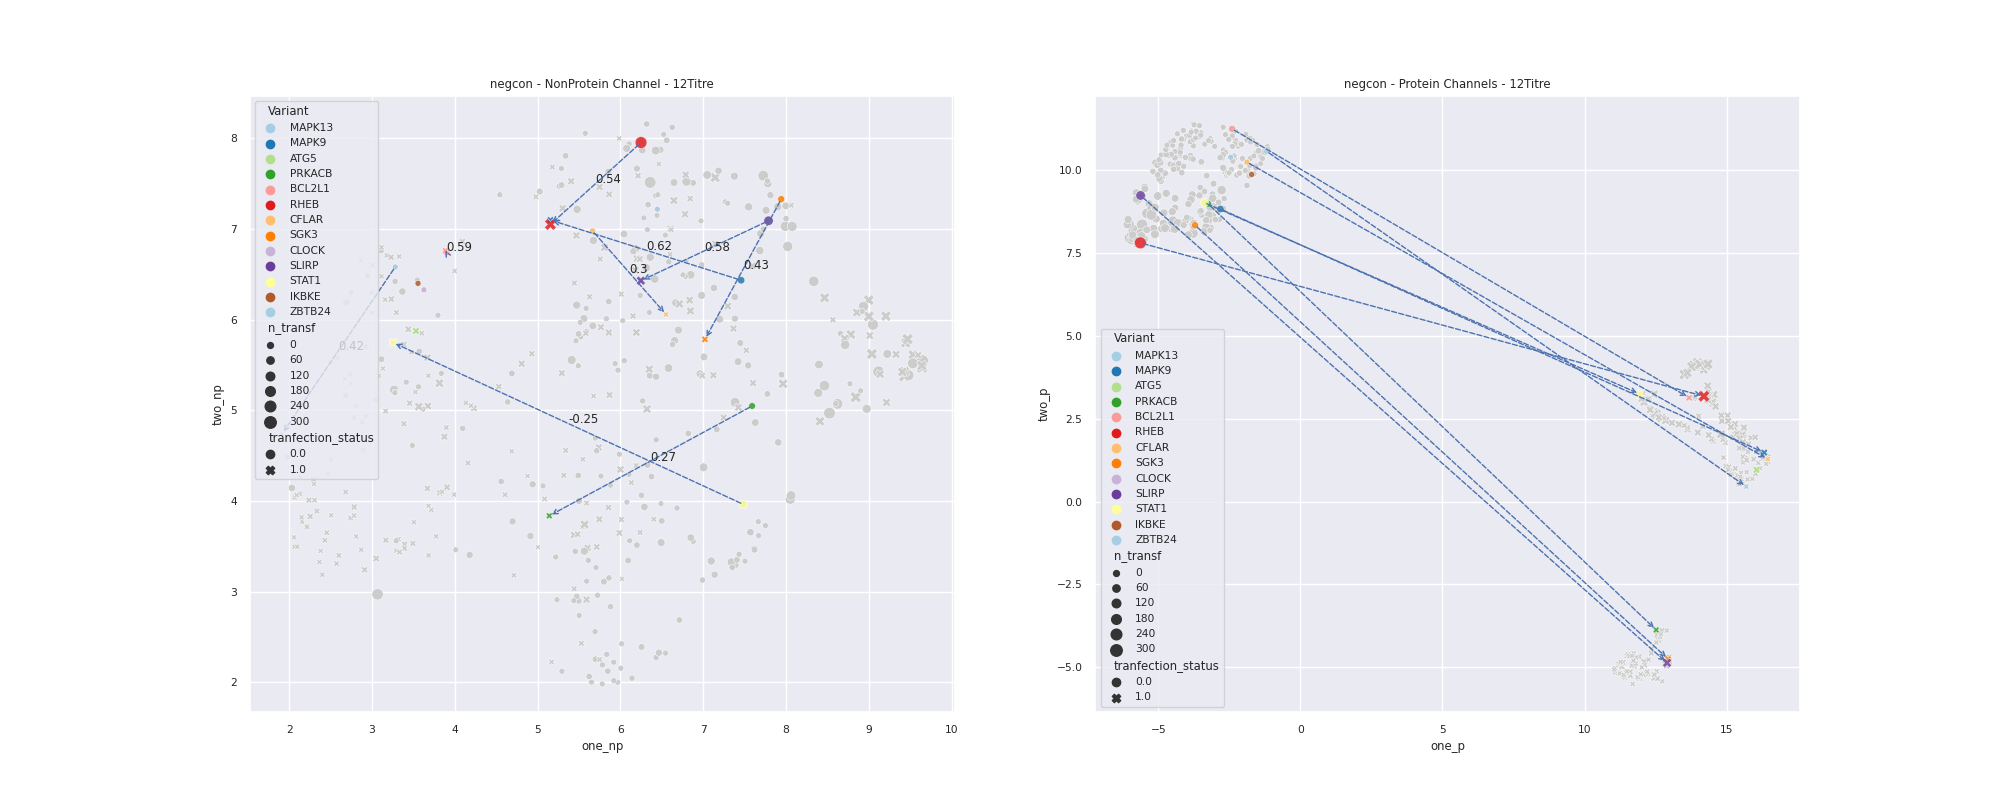

<IPython.core.display.Javascript object>


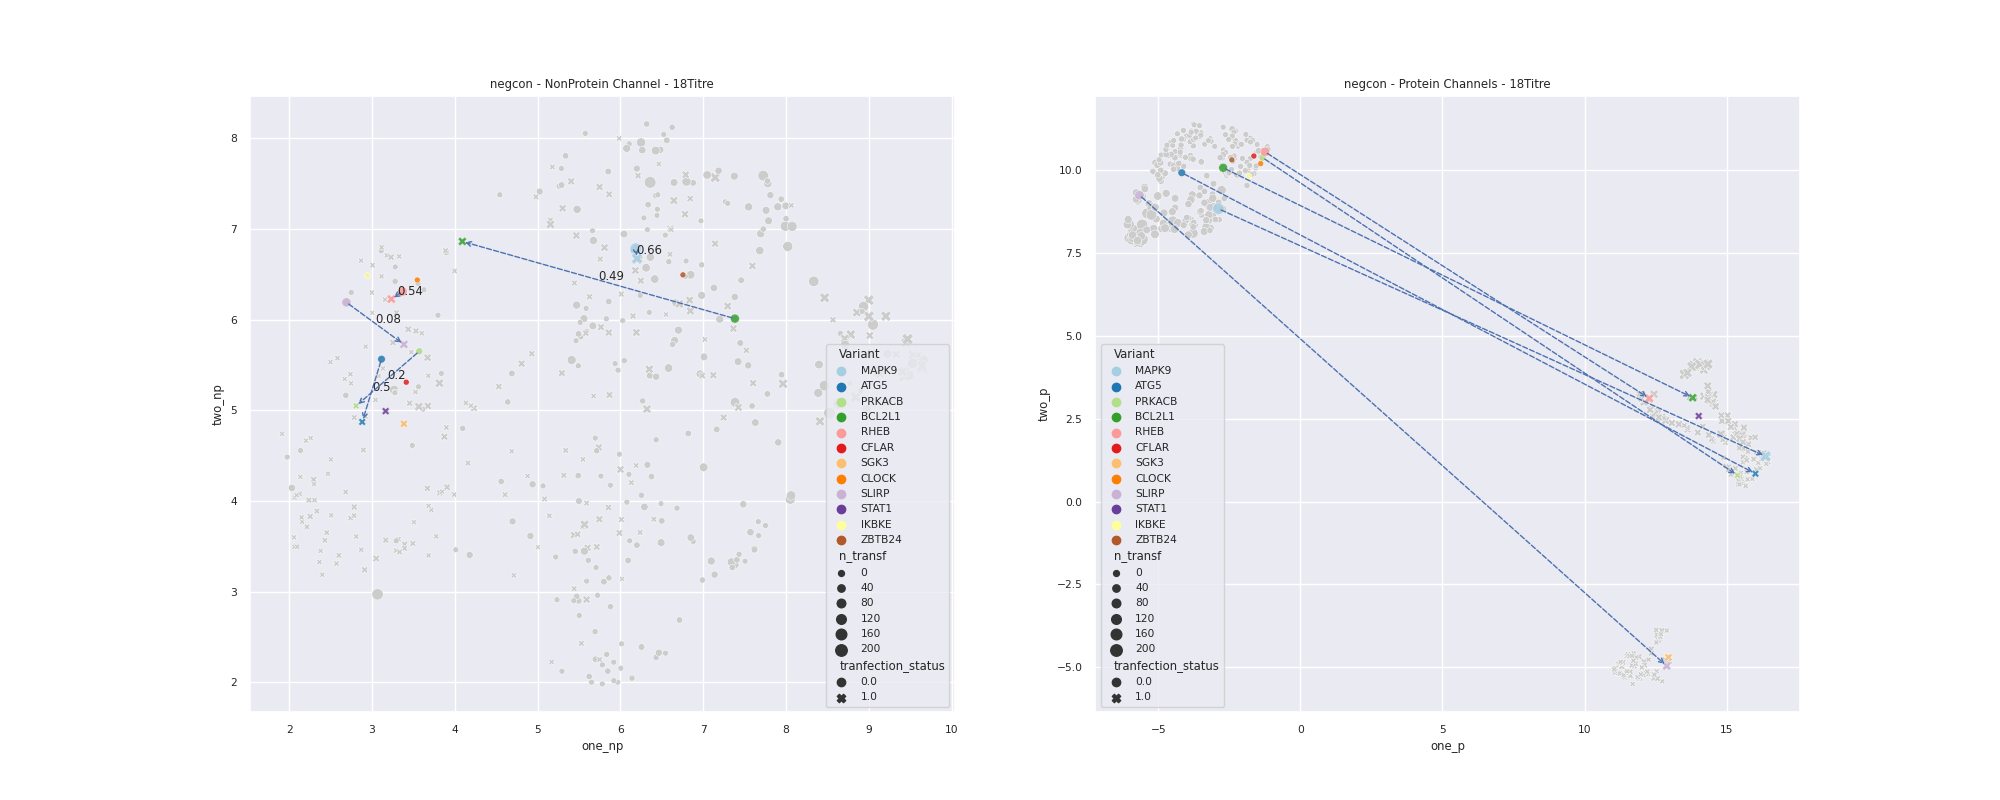

In [290]:
import umap
# vcolors=['royalblue','g','red','brown','hotpink','lightgreen','slateblue']

results_df_negcon= pd.DataFrame(columns = ['Variant','control_type', 'vTitre', 'channel','impact_versus_untransfected'])

for control_type in ['negcon']:
    
    for vt in [3,6,12,18]:
        xcon=df_selected_pop_profiles[(df_selected_pop_profiles['control_type']==control_type) &\
                                     (df_selected_pop_profiles['vTitre']==vt)].reset_index(drop=True)    
    


        ls_of_vars=xcon['Gene'].unique()
        palette = sns.color_palette("Paired",len(ls_of_vars))
    #     for g in genes:
    #         xcon_g=xcon[xcon['Gene']==g]
    #         ls_of_vars=np.sort(xcon_g['Variant'].unique())

    #             plt.figure(figsize=(8,8))
    #     palette = {}
    #     for i1 in range(len(ls_of_vars)):
    #         palette[ls_of_vars[i1]]=vcolors[i1]            


        fig, ax = plt.subplots(1,2,figsize=(20,8))
        for fi,f,ch,t in zip([0,1],[cpFeats_NP,cpFeats_P],['np','p'],['NonProtein Channel','Protein Channels']):   

            ax[fi].set_title(control_type+' - '+ t+' - '+str(vt)+ 'Titre')
            sns.scatterplot(x='one_'+ch, y='two_'+ch,size="n_transf", data=df_selected_pop_profiles,color=".8",\
                            style="tranfection_status",ax=ax[fi],legend=False);
            sns.scatterplot(x='one_'+ch, y='two_'+ch, hue="Variant",size="n_transf",style="tranfection_status",\
                            data=xcon,palette=palette,alpha=0.8,legend=True,ax=ax[fi]);

#             i=0
            
            for v in ls_of_vars:
                xcon_gv=xcon[xcon['Variant']==v].reset_index(drop=True)

                res_ls=[v,control_type,vt,ch]
                if xcon_gv['tranfection_status'].unique().shape[0]==2:
                    
                    if ch=='np':
                        cc_to_untrans=np.round(scipy.stats.pearsonr(xcon_gv.loc[xcon_gv['tranfection_status']==0,f].mean().values,\
                                                        xcon_gv.loc[xcon_gv['tranfection_status']==1,f].mean().values)[0],2)
                        cc_to_untrans_str=str(cc_to_untrans)
                        res_ls+=[cc_to_untrans]
                    else:
                        repCorr_df_avg.loc[(repCorr_df_avg['Variant']==v) & (repCorr_df_avg['vTitre']==vt) &\
                                           (repCorr_df_avg['channel']==ch),\
                                   'impact_vs_wt']=cc_wt_mt_p
                        
                        cc_to_untrans_str=''
                        res_ls+=[np.nan]

                    pX_wt,pY_wt=xcon_gv.loc[(xcon_gv['tranfection_status']==0) , ['one_'+ch,'two_'+ch]].mean()
                    pX_mt,pY_mt=xcon_gv.loc[(xcon_gv['tranfection_status']==1) , ['one_'+ch,'two_'+ch]].mean()
    #                 pX_wt,pY_wt=WT_dmso[['one_'+ch,'two_'+ch]].mean().values
    #                 pX_mt,pY_mt=MT_dmso[['one_'+ch,'two_'+ch]].mean().values
                    ax[fi].annotate('', xy=(pX_mt,pY_mt), xytext=(pX_wt, pY_wt),\
                                arrowprops=dict(arrowstyle="->",color='b',ls='dashed'),va='center')
                    ax[fi].annotate(cc_to_untrans_str,xy=(((pX_mt+pX_wt)/2), (pY_mt+pY_wt)/2))
#                     i+=1
                else:
                    res_ls+=[np.nan]
            
                results_df_negcon.loc[len(results_df_negcon)] = res_ls

In [19]:
# print(results_df_negcon.to_markdown())
repCorr_df_avg.loc[(repCorr_df_avg['Variant']==v) & (repCorr_df_avg['vTitre']==vt),:]

KeyError: 'vTitre'

In [20]:
# results_df_negcon.Variant.unique()
repCorr_df_avg

Variant  RepCor_p  Rand90Perc_p  \
0                                   ACSF3  0.464247       0.27562   
1                         ACSF3_PRO243LEU   0.78155       0.27562   
2                                    ACY1  0.601593       0.27562   
3                           AGXT_ARG36CYS  0.026515       0.27562   
4                          AGXT_GLY116ARG  0.581136       0.27562   
5                                  IMPDH1    0.8263       0.27562   
6                                  MAPK13  0.569799       0.27562   
7                         ACSF3_MET266VAL  0.548294       0.27562   
8                         ACSF3_THR358ILE  0.791574       0.27562   
9                                  ADIPOQ  0.378324       0.27562   
10                          AGXT_GLY41ARG   0.46064       0.27562   
11                         AGXT_ARG118CYS  0.760736       0.27562   
12                           IMPDH1_R309P  0.686838       0.27562   
13                                  MAPK9  0.868887       0.27562   
14                        ACSF3_GLY119ASP  0.677298       0.27562   
15                        ACSF3_PRO285LEU  0.814984       0.27562   
16                                    AGX  0.884426       0.27562   
17                          AGXT_GLY41GLU    0.4088       0.27562   
18                         AGXT_ASP129HIS  0.840433       0.27562   
19                                   ATG5   0.88402       0.27562   
20                                 PRKACB  0.483937       0.27562   
21                        ACSF3_ALA197THR  0.718377       0.27562   
22                        ACSF3_GLU359LYS  0.621569       0.27562   
23                          AGXT_MET49LEU  0.767518       0.27562   
24                         AGXT_PHE152ILE  0.769871       0.27562   
25                           IMPDH1_V353I    0.9053       0.27562   
26                                 BCL2L1  0.900296       0.27562   
27                                   RHEB  0.509347       0.27562   
28                        ACSF3_MET198ARG  0.318605       0.27562   
29                        ACSF3_ARG471TRP  0.636535       0.27562   
30                           AGXT_PRO10AL  0.764129       0.27562   
31                         AGXT_GLY161SER  0.520356       0.27562   
32                           IMPDH1_H457P  0.695327       0.27562   
33                                   SGK3  0.763358       0.27562   
34                         ACSF3_ILE200ME  0.851562       0.27562   
35                        ACSF3_ARG558TRP  0.807143       0.27562   
36                          AGXT_PRO11HIS  0.493971       0.27562   
37                          AGXT_GLY82ARG  0.871892       0.27562   
38                                    ALK   0.90219       0.27562   
39                                  SLIRP  0.803155       0.27562   
40                        ACSF3_GLY225ARG  0.667611       0.27562   
41                         ACSF3_ASP457AS  0.386095       0.27562   
42                                   ACTB  0.554377       0.27562   
43                          AGXT_LYS12ARG  0.373576       0.27562   
44                          AGXT_ALA85ASP  0.653988       0.27562   
45  RASA1_(ENDO-FREE,_HAND_PREP)_GLU70GLY   0.75082       0.27562   
46                                  STAT1  0.417606       0.27562   
47                                  ACTN1  0.758385       0.27562   
48                          AGXT_ASN22SER  0.836479       0.27562   
49                          AGXT_ARG111GL  0.858474       0.27562   
50   TPM1_(ENDO-FREE,_HAND_PREP)_ASP175AS  0.402873       0.27562   
51                             ALK_R1275Q  0.136352       0.27562   

    Rep10Perc_p RepCor_np  Rand90Perc_np  Rep10Perc_np  
0      0.387773 -0.087689       0.255331      0.048729  
1      0.387773  0.328267       0.255331      0.048729  
2      0.387773  0.650239       0.255331      0.048729  
3      0.387773 -0.029084       0.255331      0.048729  
4      0.387773  0.378216       0.255331      0.048729  
5      0.387773  0.230296       0.

In [302]:
results_df.Variant.unique()

array(['IMPDH1', 'IMPDH1_D311', 'IMPDH1_H457P', 'IMPDH1_R309P',
       'IMPDH1_V353I', 'ALK', 'ALK_A1234', 'ALK_R1275Q', 'ALK_T1151M',
       'ALK_F1174L'], dtype=object)

In [257]:
palette = sns.color_palette("Paired",20)

In [260]:
palette[1]

(0.12156862745098039, 0.47058823529411764, 0.7058823529411765)